# Zeolite classifier + SHAP analysis for *ZeoSyn: A Comprehensive Zeolite Synthesis Dataset Enabling Machine-learning Rationalization of Hydrothermal Parameters*

Elton Pan,† Soonhyoung Kwon,‡ Zach Jensen,† Mingrou Xie,‡ Rafael Gomez-Bombarelli,† Manuel Moliner,¶ Yuriy Roman,‡ and Elsa Olivetti∗,†

† Department of Materials Science and Engineering, Massachusetts Institute of Technology, Cambridge, Massachusetts 02139, United States

‡ Department of Chemical Engineering, Massachusetts Institute of Technology, Cambridge, Massachusetts 02139, United States

¶ Instituto de Tecnolog ́ıa Qu ́ımica, Universitat Politecnica de Valencia-Consejo Superior de
Investigaciones Cient ́ıficas, 46022 Valencia, Spain

In [1]:
import os
os.chdir('../')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math
import pickle
import os
import re
import shap
import imageio as iio
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from sklearn.manifold import TSNE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, RocCurveDisplay, auc
from matplotlib.colors import LogNorm, ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from utils import rename_disordered_interrupted, clean_cbus, cols_to_drop, osda_cols, X_cols, s_pore, m_pore, l_pore, xl_pore, small_cbus, large_cbus

plt.rc('font', family='Helvetica')

In [3]:
# Load synthesis dataset
df      = pd.read_excel('dataset/ZEOSYN.xlsx')

# Load zeolite structural descriptors
df_zeos = pd.read_csv('dataset/zeolite_descriptors.csv').rename(columns = {'Unnamed: 0': 'Code'})

# Load osda descriptors
df_osda = pd.read_csv('dataset/osda_descriptors.csv').drop(columns = {'Unnamed: 0': 'Code'})

In [4]:
# Retain only alumino-silicate zeolites - For Soon's 4 zeolites
constraint = 'SiAlP_ratios_low_Na'
df = df[(df['Si'] > 0.) & \
       (df['Al'] > 0.) & \
    (df['P'] == 0.)
    ]
df

Unnamed: 0        Si        Al    P        Na    K        Li   Sr   Rb  \
5               5  0.021368  0.008547  0.0  0.000000  0.0  0.004274  0.0  0.0   
6               6  0.029197  0.003650  0.0  0.000000  0.0  0.000000  0.0  0.0   
87             87  0.009619  0.000096  0.0  0.001924  0.0  0.000000  0.0  0.0   
92             92  0.152091  0.007605  0.0  0.000000  0.0  0.000000  0.0  0.0   
93             93  0.150943  0.015094  0.0  0.000000  0.0  0.000000  0.0  0.0   
...           ...       ...       ...  ...       ...  ...       ...  ...  ...   
30159       30159  0.967742  0.032258  0.0  0.000000  0.0  0.000000  0.0  0.0   
30160       30160  0.975610  0.024390  0.0  0.000000  0.0  0.000000  0.0  0.0   
30161       30161  0.985915  0.014085  0.0  0.000000  0.0  0.000000  0.0  0.0   
30162       30162  0.990099  0.009901  0.0  0.000000  0.0  0.000000  0.0  0.0   
30163       30163  0.996678  0.003322  0.0  0.000000  0.0  0.000000  0.0  0.0   

        Cs  ...                          osda1 smiles  osda2 smiles  \
5      0.0  ...                      CC[N+](CC)(CC)CC  C[N+](C)(C)C   
6      0.0  ...                      CC[N+](CC)(CC)CC  C[N+](C)(C)C   
87     0.0  ...                   CN1C(C)(C)CCCC1(C)C          NCCN   
92     0.0  ...  C[C@H]1CCC[C@@H](C)[N+]12Cc1ccccc1C2           NaN   
93     0.0  ...  C[C@H]1CCC[C@@H](C)[N+]12Cc1ccccc1C2           NaN   
...    ...  ...                                   ...           ...   
30159  0.0  ...          CC[N+]1(CC)CC2CC3CC(C2)CC1C3           NaN   
30160  0.0  ...          CC[N+]1(CC)CC2CC3CC(C2)CC1C3           NaN   
30161  0.0  ...          CC[N+]1(CC)CC2CC3CC(C2)CC1C3           NaN   
30162  0.0  ...          CC[N+]1(CC)CC2CC3CC(C2)CC1C3           NaN   
30163  0.0  ...          CC[N+]1(CC)CC2CC3CC(C2)CC1C3           NaN   

       osda3 smiles  osda1 formula  osda2 formula  osda3 formula  Code1  \
5               NaN         C8H20N         C4H12N            NaN    BPH   
6               NaN         C8H20N         C4H12N            NaN    UFI   
87              NaN        C10H21N         C2H8N2            NaN    RTH   
92              NaN        C15H22N            NaN            NaN    IRR   
93              NaN        C15H22N            NaN            NaN    IRR   
...             ...            ...            ...            ...    ...   
30159           NaN        C14H26N            NaN            NaN    CHA   
30160           NaN        C14H26N            NaN            NaN    CHA   
30161           NaN        C14H26N            NaN            NaN    AFI   
30162           NaN        C14H26N            NaN            NaN    AFI   
30163           NaN        C14H26N            NaN            NaN    AFI   

       Code2  Code3    year  
5        NaN    NaN  2003.0  
6        NaN    NaN  2003.0  
87       NaN    NaN  2009.0  
92       NaN    NaN  2010.0  
93       NaN    NaN  2010.0  
...      ...    ...     ...  
30159    NaN    NaN  2000.0  
30160    NaN    NaN  2000.0  
30161    NaN    NaN  2000.0  
30162    NaN    NaN  2000.0  
30163    NaN    NaN  2000.0  

[10763 rows x 100 columns]

In [5]:
for col in ['Al', 'P', 'Na', 'K', 'Li', 'Sr', 'Rb', 'Cs', 'Ba',
       'Ca', 'F', 'Ge', 'Ti', 'In', 'B', 'Mg', 'Ga', 'Ni', 'Mn', 'Fe', 'Co',
       'Cr', 'Zn', 'Nb', 'Be', 'W', 'Ce', 'Cu', 'Sn', 'Gd', 'La', 'Y', 'Dy',
       'Sm', 'Ag', 'Cd', 'Zr', 'V', 'H2O', 'solvent', 'sda1', 'sda2', 'sda3',
       'acid', 'Ta', 'Ru', 'Hf', 'Yb', 'Tl', 'As', 'OH']:
    df[f'{col}/Si'] = df[col] / df['Si']
    df = df.drop(columns=col)
df = df.drop(columns='Si')
df 

Unnamed: 0                     doi normed  seed  aging_time  \
5               5  10.1002/anie.200250076    yes   0.0        24.0   
6               6  10.1002/anie.200250076    yes   NaN        18.0   
87             87  10.1002/anie.200905214    yes   2.0         NaN   
92             92  10.1002/anie.201001506    yes   NaN         NaN   
93             93  10.1002/anie.201001506    yes   NaN         NaN   
...           ...                     ...    ...   ...         ...   
30159       30159       10.1021/ja990722u    yes   NaN         NaN   
30160       30160       10.1021/ja990722u    yes   NaN         NaN   
30161       30161       10.1021/ja990722u    yes   NaN         NaN   
30162       30162       10.1021/ja990722u    yes   NaN         NaN   
30163       30163       10.1021/ja990722u    yes   NaN         NaN   

       aging_temp  cryst_time  cryst_temp rotation Seed_type  ...  sda2/Si  \
5            95.0        72.0       125.0       no       NaN  ...    0.400   
6            95.0        96.0       150.0      NaN       NaN  ...    0.125   
87            NaN       168.0       170.0      yes  B-Rub-13  ...    2.000   
92            NaN        24.0       175.0      NaN       NaN  ...    0.000   
93            NaN        24.0       175.0      NaN       NaN  ...    0.000   
...           ...         ...         ...      ...       ...  ...      ...   
30159         NaN         NaN       135.0      yes       NaN  ...    0.000   
30160         NaN         NaN       160.0      yes       NaN  ...    0.000   
30161         NaN         NaN       170.0      yes       NaN  ...    0.000   
30162         NaN         NaN       170.0      yes       NaN  ...    0.000   
30163         NaN         NaN       160.0      yes       NaN  ...    0.000   

      sda3/Si acid/Si Ta/Si Ru/Si Hf/Si Yb/Si Tl/Si As/Si OH/Si  
5         0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   3.2  
6         0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  
87        0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
92        0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
93        0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...       ...     ...   ...   ...   ...   ...   ...   ...   ...  
30159     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30160     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30161     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30162     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30163     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[10763 rows x 99 columns]

In [6]:
# Filter out outliers with extremely high Na/Si ratios
df = df[df['Na/Si']<1.]

# Merge datasets: Zeolites synthesis + OSDA features

In [7]:
unique_osdas = set(df['osda1 smiles'].value_counts().keys()) |\
set(df['osda2 smiles'].value_counts().keys()) |\
set(df['osda3 smiles'].value_counts().keys())
len(unique_osdas)

492

In [8]:
osda_feat_avail = []
osda_feat_unavail = []
for osda in unique_osdas:
    if osda in list(df_osda['osda smiles']):
        osda_feat_avail.append(osda)
    else:
        osda_feat_unavail.append(osda)
print(len(osda_feat_avail), len(osda_feat_unavail), len(unique_osdas))

441 51 492


In [9]:
# Number of synthesis datapoints without osda featurizations
df[df['osda1 smiles'].isin(osda_feat_unavail) | df['osda2 smiles'].isin(osda_feat_unavail) | df['osda3 smiles'].isin(osda_feat_unavail)]

Unnamed: 0                     doi normed  seed  aging_time  \
243           243  10.1002/anie.201610547    yes   4.0         NaN   
244           244  10.1002/anie.201610547    yes   4.0         NaN   
245           245  10.1002/anie.201610547    yes   0.0         0.0   
342           342  10.1002/anie.201909336    yes   NaN         NaN   
344           344  10.1002/anie.201909336    yes   NaN         NaN   
...           ...                     ...    ...   ...         ...   
30159       30159       10.1021/ja990722u    yes   NaN         NaN   
30160       30160       10.1021/ja990722u    yes   NaN         NaN   
30161       30161       10.1021/ja990722u    yes   NaN         NaN   
30162       30162       10.1021/ja990722u    yes   NaN         NaN   
30163       30163       10.1021/ja990722u    yes   NaN         NaN   

       aging_temp  cryst_time  cryst_temp rotation Seed_type  ...  sda2/Si  \
243           NaN         NaN       175.0      NaN       NaN  ...    0.100   
244           NaN         NaN       175.0      NaN       NaN  ...    0.067   
245           0.0         0.0       175.0      NaN       NaN  ...    0.050   
342           NaN       336.0       175.0      yes       NaN  ...    0.000   
344           NaN       336.0       175.0      yes       NaN  ...    0.000   
...           ...         ...         ...      ...       ...  ...      ...   
30159         NaN         NaN       135.0      yes       NaN  ...    0.000   
30160         NaN         NaN       160.0      yes       NaN  ...    0.000   
30161         NaN         NaN       170.0      yes       NaN  ...    0.000   
30162         NaN         NaN       170.0      yes       NaN  ...    0.000   
30163         NaN         NaN       160.0      yes       NaN  ...    0.000   

      sda3/Si acid/Si Ta/Si Ru/Si Hf/Si Yb/Si Tl/Si As/Si OH/Si  
243       0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
244       0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
245       0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
342       0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
344       0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...       ...     ...   ...   ...   ...   ...   ...   ...   ...  
30159     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30160     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30161     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30162     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
30163     0.0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[519 rows x 99 columns]

In [10]:
# Number of synthesis datapoints with osda featurizations
df_with_osda_feats = df[df['osda1 smiles'].isin(osda_feat_avail) | df['osda2 smiles'].isin(osda_feat_avail) | df['osda3 smiles'].isin(osda_feat_avail)]
print('Num. synthesis routes with OSDA features: ', len(df_with_osda_feats))
# Add osda free syntheses
df_osda_free = df[(df['osda1 smiles'].isna()) & (df['osda2 smiles'].isna()) & (df['osda2 smiles'].isna()) & (~df['Al/Si'].isna())]
df_with_osda_feats = pd.concat([df_with_osda_feats, df_osda_free])
print('Num. syn routes OSDA-free: ', len(df_osda_free))
print('Num. total synthesis routes (with OSDA features + OSDA-free): ', len(df_with_osda_feats))
df_with_osda_feats

Num. synthesis routes with OSDA features:  7778
Num. syn routes OSDA-free:  1461
Num. total synthesis routes (with OSDA features + OSDA-free):  9239


Unnamed: 0                      doi normed  seed  aging_time  \
5               5   10.1002/anie.200250076    yes   0.0        24.0   
6               6   10.1002/anie.200250076    yes   NaN        18.0   
87             87   10.1002/anie.200905214    yes   2.0         NaN   
92             92   10.1002/anie.201001506    yes   NaN         NaN   
93             93   10.1002/anie.201001506    yes   NaN         NaN   
...           ...                      ...    ...   ...         ...   
29728       29728  10.1515/revce-2013-0020    yes   NaN         NaN   
29729       29729  10.1515/revce-2013-0020    yes   NaN         NaN   
29730       29730  10.1515/revce-2013-0020    yes   NaN         NaN   
29732       29732  10.1515/revce-2013-0020    yes   NaN         NaN   
29733       29733  10.1515/revce-2013-0020    yes   NaN         NaN   

       aging_temp  cryst_time  cryst_temp rotation Seed_type  ...  sda2/Si  \
5            95.0        72.0       125.0       no       NaN  ...    0.400   
6            95.0        96.0       150.0      NaN       NaN  ...    0.125   
87            NaN       168.0       170.0      yes  B-Rub-13  ...    2.000   
92            NaN        24.0       175.0      NaN       NaN  ...    0.000   
93            NaN        24.0       175.0      NaN       NaN  ...    0.000   
...           ...         ...         ...      ...       ...  ...      ...   
29728         NaN       168.0       150.0     True       NaN  ...    0.000   
29729         NaN        68.0       200.0    False       NaN  ...    0.000   
29730         NaN        70.0       200.0    False       NaN  ...    0.000   
29732         NaN        24.0       200.0    False       NaN  ...    0.000   
29733         NaN        24.0       200.0    False       NaN  ...    0.000   

      sda3/Si acid/Si Ta/Si Ru/Si Hf/Si Yb/Si     Tl/Si As/Si     OH/Si  
5         0.0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0  3.200000  
6         0.0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0  2.000000  
87        0.0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000  
92        0.0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000  
93        0.0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0  0.000000  
...       ...     ...   ...   ...   ...   ...       ...   ...       ...  
29728     0.0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0  0.133333  
29729     0.0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0  0.128278  
29730     0.0     0.0   0.0   0.0   0.0   0.0  0.000000   0.0  0.128016  
29732     0.0     0.0   0.0   0.0   0.0   0.0  2.097902   0.0  1.118881  
29733     0.0     0.0   0.0   0.0   0.0   0.0  2.097902   0.0  1.118881  

[9239 rows x 99 columns]

In [11]:
# Select osda features
dfs_with_osda_cols = [] # list of dfs (to be concatenated)
for osda_col in osda_cols:
    df_with_osda_col = df_osda.loc[:, df_osda.columns.str.contains(osda_col)] # one df containing that column
    dfs_with_osda_cols.append(df_with_osda_col)
dfs_with_osda_cols.append(df_osda.loc[:, df_osda.columns.str.contains('osda smiles')])

df_selected_osda_cols = pd.concat(dfs_with_osda_cols, axis = 1) # concat these dfs
df_selected_osda_cols # df of osdas with features in osda_cols variable

asphericity_mean_0  asphericity_std_0  axes_mean_0  axes_mean_1  \
0              0.833046           0.090677     2.844355     5.873985   
1              0.862392           0.008930     4.911553    18.135735   
2              0.871083           0.011571     4.909037    16.996942   
3              0.827862           0.010274     4.521435    15.865518   
4              0.846011           0.018141     4.870309    16.364766   
..                  ...                ...          ...          ...   
838            0.334574           0.070111     6.744544    10.353599   
839            0.445281           0.120964     7.320686    13.834375   
840            0.473344           0.000000     7.100301    11.389339   
841            0.570104           0.000000     4.978538     9.194406   
842            0.250123           0.000000     3.883313     4.305437   

     axes_std_0  axes_std_1  bertz_ct_mean_0  eccentricity_mean_0  \
0      0.344235    0.687441       188.361619             0.997548   
1      0.236299    0.106522      1761.127185             0.998815   
2      0.214486    0.395254      1677.990439             0.998962   
3      0.162815    0.136168      1570.117276             0.998080   
4      0.434798    0.258982      1584.716532             0.998478   
..          ...         ...              ...                  ...   
838    0.451135    0.495314      1031.770424             0.944772   
839    0.460630    1.445857      1435.155855             0.960395   
840    0.000000    0.000000      1660.979191             0.973860   
841    0.000000    0.000000       934.634999             0.984861   
842    0.000000    0.000000       271.164518             0.869696   

     eccentricity_std_0  formal_charge  ...  whim_mean_105  whim_mean_106  \
0              0.002453              0  ...       0.506714       0.529286   
1              0.000150              2  ...       0.540200       0.477300   
2              0.000191              2  ...       0.550375       0.486500   
3              0.000244              2  ...       0.556100       0.487150   
4              0.000403              2  ...       0.553500       0.491250   
..                  ...            ...  ...            ...            ...   
838            0.023241              0  ...       0.509391       0.386565   
839            0.047998              0  ...       0.485884       0.380767   
840            0.000000              0  ...       0.573000       0.452000   
841            0.000000              0  ...       0.529000       0.417000   
842            0.000000              0  ...       0.543000       0.436000   

     whim_mean_107  whim_mean_108  whim_mean_109  whim_mean_110  \
0        10.965571      14.641857      10.375429      11.372000   
1       201.261200     112.928400     145.588100     197.331400   
2       195.761375     111.017625     142.011250     191.894875   
3       150.820550      81.970050     107.526400     147.553550   
4       176.277750     101.413250     128.584750     172.836500   
..             ...            ...            ...            ...   
838      76.609087      43.799130      55.770652      72.874826   
839     148.158814      88.934488     111.403186     140.810047   
840      51.201000      28.138000      33.756000      50.089000   
841      28.916000      15.015000      18.676000      28.069000   
842       7.139000       3.421000       4.387000       6.943000   

     whim_mean_111  whim_mean_112  whim_mean_113  \
0        11.822286      11.203857      12.580714   
1       161.063400     207.634000     182.704900   
2       156.960875     201.762000     177.661750   
3       119.707300     155.615100     136.211650   
4       141.807000     181.597750     160.566000   
..             ...            ...            ...   
838      62.931522      79.027087      60.637739   
839     124.675349     152.258953     118.900930   
840      37.100000      54.878000      42.793000   
841      20.837000      30.728000      22.907000   
842      

In [12]:
# Merge: 1) df of synthesis with osda featurizations 2) df of osdas with features in osda_cols variable

# Add OSDA1 first
df_syn_osda = df_with_osda_feats.merge(df_selected_osda_cols.add_prefix('osda1_'), left_on='osda1 smiles', right_on='osda1_osda smiles', how = 'outer')
df_syn_osda = df_syn_osda[~df_syn_osda['Unnamed: 0'].isna()] # Since the line above is an 'outer' merge, need to retain only the rows of the left df

# then add OSDA2 to df_syn_osda
df_syn_osda = df_syn_osda.merge(df_selected_osda_cols.add_prefix('osda2_'), left_on='osda2 smiles', right_on='osda2_osda smiles', how = 'outer')
df_syn_osda = df_syn_osda[~df_syn_osda['Unnamed: 0'].isna()] # Since the line above is an 'outer' merge, need to retain only the rows of the left df

# then add OSDA3 to df_syn_osda
df_syn_osda = df_syn_osda.merge(df_selected_osda_cols.add_prefix('osda3_'), left_on='osda3 smiles', right_on='osda3_osda smiles', how = 'outer')
df_syn_osda = df_syn_osda[~df_syn_osda['Unnamed: 0'].isna()] # Since the line above is an 'outer' merge, need to retain only the rows of the left df

# Replace NaN in osda featurizations with 0
for osda_col in osda_cols:
    df_syn_osda.loc[:, df_syn_osda.columns.str.contains(osda_col)] = df_syn_osda.loc[:, df_syn_osda.columns.str.contains(osda_col)].fillna(0)

# Drop columns
df_syn_osda = df_syn_osda.drop(columns=[
                                        'Unnamed: 0',
                                        'osda1_osda smiles', 
                                        'osda2_osda smiles', 
                                        'osda3_osda smiles'
                                       ])

df_syn_osda

doi normed  seed  aging_time  aging_temp  \
0             10.1002/anie.200250076    yes   0.0        24.0        95.0   
1             10.1002/anie.200250076    yes   NaN        18.0        95.0   
2     10.1016/j.ijhydene.2007.08.009    yes   NaN         NaN         NaN   
3                 10.1039/c4cc10351c    yes   NaN        24.0         NaN   
4                 10.1039/c4cc10351c    yes   NaN        24.0         NaN   
...                              ...    ...   ...         ...         ...   
9234   10.1021/acs.chemmater.5b00651    yes   NaN         NaN         NaN   
9235   10.1021/acs.chemmater.5b00651    yes   NaN         NaN         NaN   
9236   10.1021/acs.chemmater.5b00651    yes   NaN         NaN         NaN   
9237   10.1021/acs.chemmater.5b00651    yes   NaN         NaN         NaN   
9238   10.1021/acs.chemmater.5b00651    yes   NaN         NaN         NaN   

      cryst_time  cryst_temp rotation Seed_type  react_vol  ...  \
0           72.0       125.0       no       NaN     2000.0  ...   
1           96.0       150.0      NaN       NaN        NaN  ...   
2          168.0       150.0      NaN       NaN        NaN  ...   
3           24.0       120.0      yes       NaN       45.0  ...   
4           48.0       120.0      yes       NaN       45.0  ...   
...          ...         ...      ...       ...        ...  ...   
9234       144.0       140.0     True       NaN        NaN  ...   
9235       144.0       140.0     True       NaN        NaN  ...   
9236        84.0       140.0     True       NaN        NaN  ...   
9237        88.8       140.0     True       NaN        NaN  ...   
9238        88.8       140.0     True       NaN        NaN  ...   

     osda3_whim_mean_104 osda3_whim_mean_105 osda3_whim_mean_106  \
0                  0.000               0.000               0.000   
1                  0.000               0.000               0.000   
2                  0.000               0.000               0.000   
3                  0.000               0.000               0.000   
4                  0.000               0.000               0.000   
...                  ...                 ...                 ...   
9234               0.324               0.453               0.381   
9235               0.324               0.453               0.381   
9236               0.324               0.453               0.381   
9237               0.324               0.453               0.381   
9238               0.324               0.453               0.381   

     osda3_whim_mean_107 osda3_whim_mean_108 osda3_whim_mean_109  \
0                    0.0               0.000               0.000   
1                    0.0               0.000               0.000   
2                    0.0               0.000               0.000   
3                    0.0               0.000               0.000   
4                    0.0               0.000               0.000   
...                  ...                 ...                 ...   
9234                27.2              12.084              17.712   
9235                27.2              12.084              17.712   
9236                27.2              12.084              17.712   
9237                27.2              12.084              17.712   
9238                27.2              12.084              17.712   

     osda3_whim_mean_110 osda3_whim_mean_111 osda3_whim_mean_112  \
0                  0.000               0.000               0.000   
1                  0.000               0.000               0.000   
2                  0.000               0.000               0.000   
3                  0.000               0.000               0.000   
4                  0.000               0.000               0.000   
...                  ...                 ...                 ...   
9234              26.445              20.426              28.203   
9235              26.445              20.426              28.203   
9236              26.445              20.426             

# Process data for multi-class classification

In [13]:
X_cols = {
 'Al/Si': 'Al/Si',
 'P/Si': 'P/Si',
 'Na/Si': 'Na/Si',
 'K/Si': 'K/Si',
 'Li/Si': 'Li/Si',
 'Sr/Si': 'Sr/Si',
 'Rb/Si': 'Rb/Si',
 'Cs/Si': 'Cs/Si',
 'Ba/Si': 'Ba/Si',
 'Ca/Si': 'Ca/Si',
 'F/Si': 'F/Si',
 'Ge/Si': 'Ge/Si',
 'Ti/Si': 'Ti/Si',
 'B/Si': 'B/Si',
 'Mg/Si': 'Mg/Si',
 'Ga/Si': 'Ga/Si',
 'Zn/Si': 'Zn/Si',
 'Be/Si': 'Be/Si',
 'W/Si': 'W/Si',
 'Cu/Si': 'Cu/Si',
 'Sn/Si': 'Sn/Si',
 'Zr/Si': 'Zr/Si',
 'V/Si': 'V/Si',
 'H2O/Si': 'H$_2$O/Si',
 'sda1/Si': 'OSDA/Si',
 'OH/Si': 'OH/Si',
 'cryst_time': 'Crystallization time',
 'cryst_temp': 'Crystallization temp',
 'osda1_asphericity_mean_0': 'OSDA asphericity',
 'osda1_axes_mean_0': 'OSDA axis 1',
 'osda1_axes_mean_1': 'OSDA axis 2',
 'osda1_formal_charge': 'OSDA charge',
 'osda1_free_sasa_mean_0': 'OSDA SASA',
 'osda1_mol_weight': 'OSDA molecular weight',
 'osda1_npr1_mean_0': 'OSDA NPR 1',
 'osda1_npr2_mean_0': 'OSDA NPR 2',
 'osda1_num_rot_bonds_mean_0': 'OSDA rotatable bonds',
 'osda1_pmi1_mean_0': 'OSDA PMI 1',
 'osda1_pmi2_mean_0': 'OSDA PMI 2',
 'osda1_pmi3_mean_0': 'OSDA PMI 3',
 'osda1_spherocity_index_mean_0': 'OSDA sphericity',
 'osda1_volume_mean_0': 'OSDA volume'}

In [14]:
# Drop columns
X = df_syn_osda.drop(columns = cols_to_drop)

# Imputation for cryst_time (1412/21972 has NaN) and cryst_temp (554/21972 has NaN)
columns = list(X.columns) # Save columns
imp = IterativeImputer(min_value = 0., sample_posterior = True, skip_complete = True, random_state=0) # Sample posterior to get a distribution, skip_complete to speed up, min value is 0. since time and temp are +ve
imp.fit(X)
X = pd.DataFrame(imp.transform(X))
X.columns = columns # Assign columns back

X_y = X
X_y['Code1'] = df_syn_osda['Code1']

# Empty 'Code1' element means amorphous/dense phases - replace with 'Failed'
X_y['Code1'] = X_y['Code1'].fillna('Failed')
X_y['Code1'].isna().sum()

# Define X and y
X = X_y.drop(columns = ['Code1'])
y = X_y['Code1']

# Feature selection
X = X[X_cols.keys()]
X.columns = X_cols.values()

In [15]:
X

Al/Si  P/Si  Na/Si  K/Si  Li/Si  Sr/Si  Rb/Si  Cs/Si  Ba/Si  Ca/Si  \
0     0.400000   0.0   0.00   0.0   0.20   0.00    0.0    0.0    0.0    0.0   
1     0.125000   0.0   0.00   0.0   0.00   0.00    0.0    0.0    0.0    0.0   
2     0.148148   0.0   0.00   0.0   0.00   0.00    0.0    0.0    0.0    0.0   
3     0.400000   0.0   0.00   0.0   0.03   0.06    0.0    0.0    0.0    0.0   
4     0.400000   0.0   0.00   0.0   0.03   0.06    0.0    0.0    0.0    0.0   
...        ...   ...    ...   ...    ...    ...    ...    ...    ...    ...   
9234  0.066000   0.0   0.51   0.0   0.00   0.00    0.0    0.0    0.0    0.0   
9235  0.066000   0.0   0.51   0.0   0.00   0.00    0.0    0.0    0.0    0.0   
9236  0.067000   0.0   0.58   0.0   0.00   0.00    0.0    0.0    0.0    0.0   
9237  0.067000   0.0   0.54   0.0   0.00   0.00    0.0    0.0    0.0    0.0   
9238  0.067000   0.0   0.54   0.0   0.00   0.00    0.0    0.0    0.0    0.0   

      ...   OSDA SASA  OSDA molecular weight  OSDA NPR 1  OSDA NPR 2  \
0     ...  344.809666                130.255    0.676673    0.816419   
1     ...  344.809666                130.255    0.676673    0.816419   
2     ...  344.809666                130.255    0.676673    0.816419   
3     ...  344.809666                130.255    0.676673    0.816419   
4     ...  344.809666                130.255    0.676673    0.816419   
...   ...         ...                    ...         ...         ...   
9234  ...  357.916974                142.266    0.572966    0.638424   
9235  ...  357.916974                142.266    0.572966    0.638424   
9236  ...  357.916974                142.266    0.572966    0.638424   
9237  ...  357.916974                142.266    0.572966    0.638424   
9238  ...  357.916974                142.266    0.572966    0.638424   

      OSDA rotatable bonds  OSDA PMI 1  OSDA PMI 2  OSDA PMI 3  \
0                      4.0  321.997036  382.792788  478.680264   
1                      4.0  321.997036  382.792788  478.680264   
2                      4.0  321.997036  382.792788  478.680264   
3                      4.0  321.997036  382.792788  478.680264   
4                      4.0  321.997036  382.792788  478.680264   
...                    ...         ...         ...         ...   
9234                   0.0  364.200627  405.808505  635.641019   
9235                   0.0  364.200627  405.808505  635.641019   
9236                   0.0  364.200627  405.808505  635.641019   
9237                   0.0  364.200627  405.808505  635.641019   
9238                   0.0  364.200627  405.808505  635.641019   

      OSDA sphericity  OSDA volume  
0            0.639849   161.284000  
1            0.639849   161.284000  
2            0.639849   161.284000  
3            0.639849   161.284000  
4            0.639849   161.284000  
...               ...          ...  
9234         0.426424   166.890667  
9235         0.426424   166.890667  
9236         0.426424   166.890667  
9237         0.426424   166.890667  
9238         0.426424   166.890667  

[9239 rows x 42 columns]

In [16]:
y

0          BPH
1          UFI
2          OFF
3       Failed
4       Failed
         ...  
9234       MOR
9235       MOR
9236       AEI
9237       AEI
9238       AEI
Name: Code1, Length: 9239, dtype: object

# Training classifier

In [17]:
# With val set
random_state = 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.125, random_state = random_state)
print(len(X_train), len(X_test), len(X_val), len(y_train), len(y_test), len(y_val) )

6467 1848 924 6467 1848 924


In [18]:
model = RandomForestClassifier(max_depth = None, random_state = random_state)
model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

# Calculate metrics with results
y_pred = model.predict(X_test)
results = classification_report(y_test, y_pred, output_dict = True) 

print('======MODEL PERFORMANCE METRICS======')
print('acc: ', results['accuracy'])
print('macro avg:', results['macro avg'])

======MODEL PERFORMANCE METRICS======
acc:  0.7283549783549783
macro avg: {'precision': 0.6434072492974784, 'recall': 0.6237215252016893, 'f1-score': 0.612363979944083, 'support': 1848}


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [19]:
# Save/load classification model
# with open(f'model/classifier_{constraint}.pkl', 'wb') as handle:
#     pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'model/classifier_{constraint}.pkl', 'rb') as handle:
    model = pickle.load(handle)

# SHAP analysis

In [20]:
# Calculate SHAP values - Note: takes about 2h 

# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)
# shap_values[0].shape

In [21]:
# Save/load SHAP values - Note: Please download and place shap_values.pkl (https://figshare.com/s/5519f7668ff2f631f47f) in the shap/ directory
# with open(f'shap/shap_values_{constraint}.pkl', 'wb') as handle:
#     pickle.dump(shap_values, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(f'shap/shap_values_{constraint}.pkl', 'rb') as handle:
    shap_values = pickle.load(handle)

In [22]:
# Mask out non-relevant features
shap_cols     = [] # columns to remain
shap_col_idxs = [] # their indices
for col_idx, col in enumerate(X_test.columns):
        shap_cols.append(col)
        shap_col_idxs.append(col_idx)

shap_values_masked = [x[:,shap_col_idxs] for x in shap_values]
X_test_masked      = X_test[shap_cols]
X_test_masked.columns = X_cols.values()
shap_values_masked[0].shape, X_test_masked.shape

((1848, 42), (1848, 42))

## Framework-level SHAP

In [23]:
from sklearn.preprocessing import QuantileTransformer
_X_test_masked = X_test_masked.copy()
for col in _X_test_masked.columns:
    if '/Si' in col:
        qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=0)
        _X_test_masked[col] = qt.fit_transform(np.array(_X_test_masked[col]).reshape(-1, 1))

_X_test_masked

Al/Si      P/Si     Na/Si      K/Si     Li/Si     Sr/Si     Rb/Si  \
3884  1.394512 -5.199338  1.179402 -5.199338 -5.199338 -5.199338 -5.199338   
3032 -1.378114 -5.199338 -0.132113 -5.199338 -5.199338 -5.199338 -5.199338   
1995  1.301191 -5.199338  0.807429 -5.199338 -5.199338 -5.199338 -5.199338   
4923  0.217488 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338   
7376  0.242339 -5.199338  0.555462 -5.199338 -5.199338 -5.199338 -5.199338   
...        ...       ...       ...       ...       ...       ...       ...   
1326  1.231280 -5.199338  1.545927 -5.199338 -5.199338 -5.199338 -5.199338   
7325 -0.927834 -5.199338 -5.199338  1.475269 -5.199338 -5.199338 -5.199338   
4359  2.032634 -5.199338  0.590949 -5.199338 -5.199338 -5.199338 -5.199338   
3849 -0.810910 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338 -5.199338   
295  -0.793602 -5.199338 -0.193143 -5.199338 -5.199338 -5.199338 -5.199338   

         Cs/Si     Ba/Si     Ca/Si  ...   OSDA SASA  OSDA molecular weight  \
3884 -5.199338 -5.199338 -5.199338  ...  421.194241                220.265   
3032 -5.199338 -5.199338 -5.199338  ...  234.004985                 59.112   
1995  1.968165 -5.199338 -5.199338  ...  485.993143                264.318   
4923 -5.199338 -5.199338 -5.199338  ...  462.176445                236.338   
7376 -5.199338 -5.199338 -5.199338  ...    0.000000                  0.000   
...        ...       ...       ...  ...         ...                    ...   
1326 -5.199338 -5.199338 -5.199338  ...  255.053766                 74.147   
7325 -5.199338 -5.199338 -5.199338  ...    0.000000                  0.000   
4359 -5.199338 -5.199338 -5.199338  ...  283.700631                 99.177   
3849 -5.199338 -5.199338 -5.199338  ...  427.563119                197.346   
295  -5.199338 -5.199338 -5.199338  ...  344.809666                130.255   

      OSDA NPR 1  OSDA NPR 2  OSDA rotatable bonds   OSDA PMI 1   OSDA PMI 2  \
3884    0.439804    0.631297                   0.0   778.452704  1119.549912   
3032    0.561611    0.590498                   0.0    60.508188    63.611847   
1995    0.413578    0.652254                   0.0  1184.080656  1878.610831   
4923    0.189718    0.963634                   0.0   442.700393  2251.377526   
7376    0.000000    0.000000                   0.0     0.000000     0.000000   
...          ...         ...                   ...          ...          ...   
1326    0.999980    0.999992                   0.0   111.023088   111.024499   
7325    0.000000    0.000000                   0.0     0.000000     0.000000   
4359    0.549502    0.598483                   0.0   155.820020   169.706727   
3849    0.186428    0.950260                   1.0   300.033728  1546.396228   
295     0.676673    0.816419                   4.0   321.997036   382.792788   

       OSDA PMI 3  OSDA sphericity  OSDA volume  
3884  1773.664828         0.211653   213.865200  
3032   107.743736         0.425202    74.098000  
1995  2879.882442         0.179591   256.640600  
4923  2335.812040         0.337336   233.164000  
7376     0.000000         0.000000     0.000000  
...           ...              ...          ...  
1326   111.025347         0.999988    94.552000  
7325     0.000000         0.000000     0.000000  
4359   283.572013         0.418394   113.141600  
3849  1628.465448         0.298526   219.346667  
295    478.680264         0.639849   161.284000  

[1848 rows x 42 columns]

In [24]:
def plot_zeo_shap(zeo, cols, max_display = 5, plot_size = (8,5), xlim = None, alpha = 0.1, cmap = 'coolwarm', xlabel_size = None, color_bar = True, sort = True, return_top_shap_feats = False, savepath = None):
    '''
    Plots SHAP plot for a specific zeolite
    
    Args:
    zeo: zeolite 3-letter code
    cols: synthesis feature columns to consider
    '''
    
    zeo_idx = np.where(model.classes_ == zeo)[0][0] # Find class index
    
    zeo_shap = pd.DataFrame(shap_values_masked[zeo_idx], columns = X_cols.values())[cols]  # Get SHAP values for zeo
    
    # Summary plot
    plt.figure(dpi = 300)
    shap.summary_plot(np.array(zeo_shap), _X_test_masked[cols],
                    max_display = max_display,
                    cmap = cmap,
                    show = False, 
                    alpha = alpha, 
                    color_bar = color_bar,
                    color_bar_label='Synthesis parameter',
                    plot_size = plot_size,
                    sort = sort,
                     )

    fig, ax = plt.gcf(), plt.gca()

    ax.set_xlabel('SHAP contribution to \n' + r'$\bf{' + zeo + '}$ formation', fontsize = xlabel_size)
    plt.xticks(fontsize=15)
    
    if xlabel_size != None:
        ax.tick_params(axis='y', which='major', labelsize=xlabel_size)
    
    top_shap_feat = ax.get_yticklabels()[-1].get_text() # str of feature name
    top_shap_feat_ub = np.quantile(zeo_shap[top_shap_feat], 0.99)*1.2 # upper
    top_shap_feat_lb = np.quantile(zeo_shap[top_shap_feat], 0.01)*1.2 # lower

    if xlim != None:
        ax.set_xlim(*xlim)
    else:
        ax.set_xlim(-max([top_shap_feat_ub, top_shap_feat_lb]), max([top_shap_feat_ub, top_shap_feat_lb]))
    
    plt.xticks([0.])
    
    if savepath != None:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    
    if return_top_shap_feats: # return a list of top SHAP features
        top_shap_feats = [ax.get_yticklabels()[-i].get_text() for i in range(max_display)]
        plt.close(fig)
        return top_shap_feats
    else:
        plt.show()


def moving_average_smoothing_with_padding(data, window_size):
    """
    Smooths the input data using a moving average while keeping the same number of data points.
    
    Parameters:
    - data: list or numpy array of data points.
    - window_size: the size of the window for the moving average.

    Returns:
    - smoothed_data: numpy array of smoothed data with the same length as the input.
    """
    # Ensure window_size is odd, so we have a symmetric window
    if window_size % 2 == 0:
        window_size += 1

    half_window = window_size // 2
    
    # Pad the data by replicating the boundary values
    padded_data = np.pad(data, pad_width=half_window, mode='edge')
    
    # Apply the moving average smoothing
    smoothed_data = np.convolve(padded_data, np.ones(window_size)/window_size, mode='valid')
    
    return smoothed_data

def dependence_plot(zeo, feat, xmin=None, xmax=None, top_n=1, smooth=False):
    zeo_idx = np.where(model.classes_ == zeo)[0][0]
    feat_idx = np.where(np.array(list(X_cols.values())) == feat)[0][0]

    # shap.dependence_plot(feat, shap_values[zeo_idx], X_test_masked, xmin=xmin, xmax=xmax, interaction_index=None)
    feat_val_vs_shap_val = pd.DataFrame({f'{feat}': X_test_masked[feat], 'SHAP value': shap_values[zeo_idx][:, feat_idx]}).sort_values(feat)
    plt.figure(figsize=(7,5), dpi=100)
    if smooth:
        plt.plot(feat_val_vs_shap_val[feat], moving_average_smoothing_with_padding(feat_val_vs_shap_val['SHAP value'], 5))
    else:
        plt.plot(feat_val_vs_shap_val[feat], feat_val_vs_shap_val['SHAP value'])
    plt.xlim(xmin, xmax)
    plt.xlabel(feat, fontsize=20)
    plt.ylabel('SHAP contribution', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    print(feat_val_vs_shap_val[feat_val_vs_shap_val[feat]>0.].sort_values('SHAP value', ascending=False).head(top_n).mean())

# SHAP Analysis for KFI/RHO/LTA/UFI paper

In [25]:
cmap = 'inferno'

K/Si          0.432342
SHAP value    0.098261
dtype: float64
Sr/Si         0.010000
SHAP value    0.074046
dtype: float64
OH/Si         0.457600
SHAP value    0.053264
dtype: float64
H$_2$O/Si     10.794627
SHAP value     0.070776
dtype: float64
Crystallization temp    130.000000
SHAP value                0.063872
dtype: float64


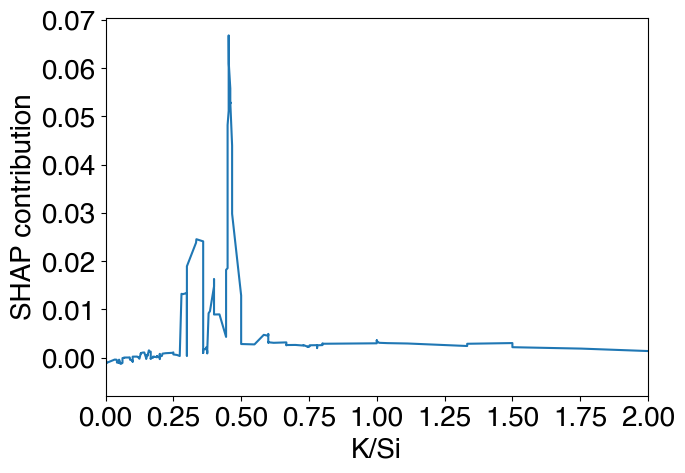

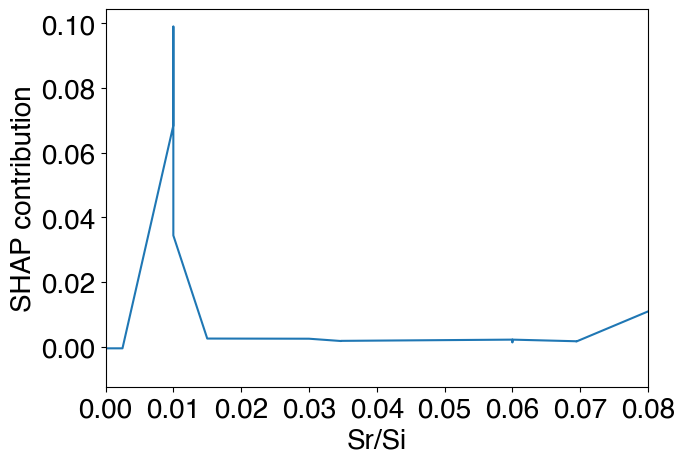

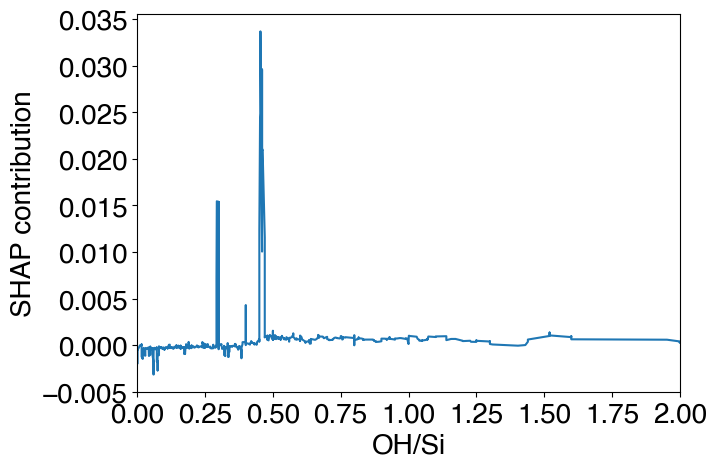

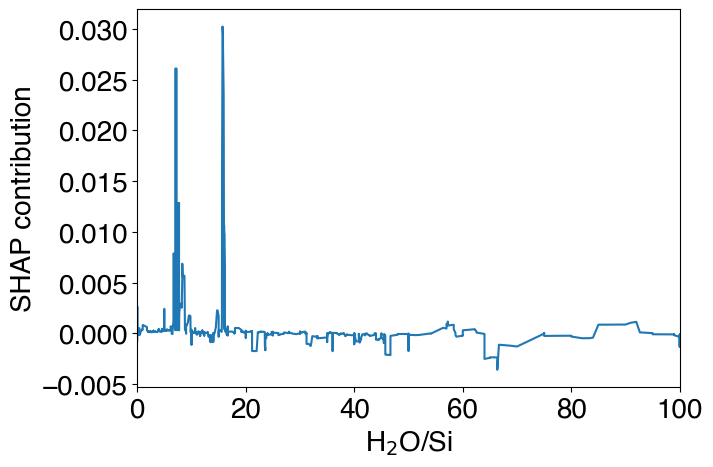

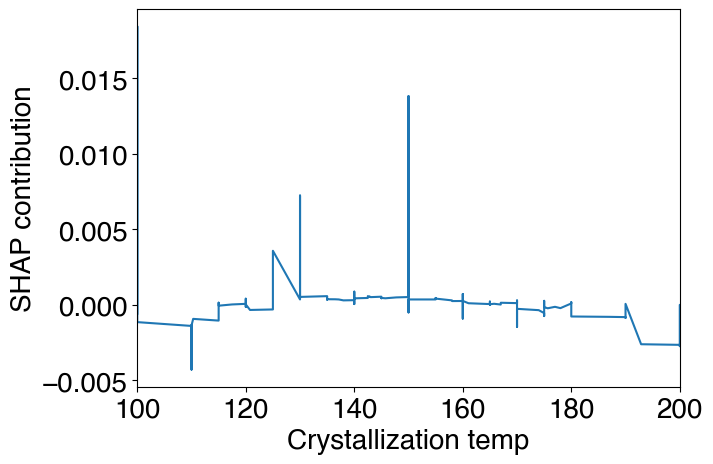

In [46]:
dependence_plot(zeo='KFI', feat='K/Si', xmin=0., xmax=2., top_n=5, smooth=True)
dependence_plot(zeo='KFI', feat='Sr/Si', xmin=0., xmax=0.08, top_n=5, smooth=False)
dependence_plot(zeo='KFI', feat='OH/Si', xmin=0., xmax=2., top_n=5, smooth=True)
dependence_plot(zeo='KFI', feat='H$_2$O/Si', xmin=0., xmax=100., top_n=5, smooth=True)
dependence_plot(zeo='KFI', feat='Crystallization temp', xmin=100., xmax=200., top_n=5, smooth=True)

Cs/Si         0.049371
SHAP value    0.119115
dtype: float64
Na/Si         0.281219
SHAP value    0.051012
dtype: float64
OH/Si         0.053813
SHAP value    0.049706
dtype: float64
H$_2$O/Si     8.771209
SHAP value    0.062690
dtype: float64
Crystallization temp    100.000000
SHAP value                0.075033
dtype: float64


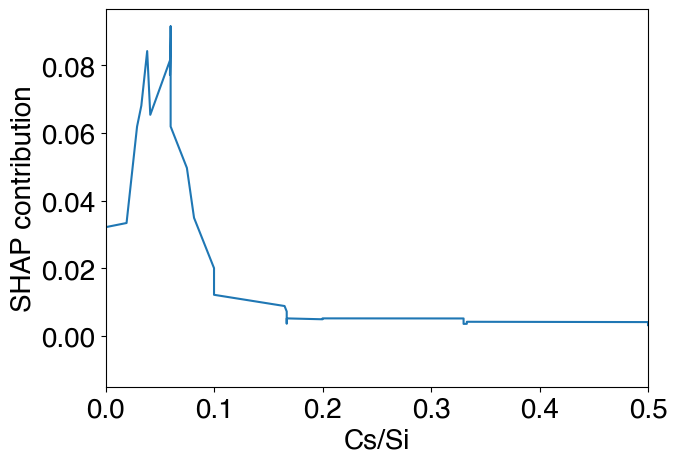

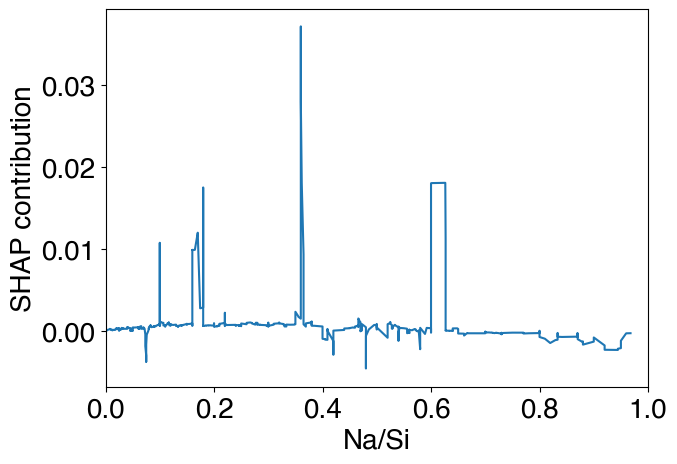

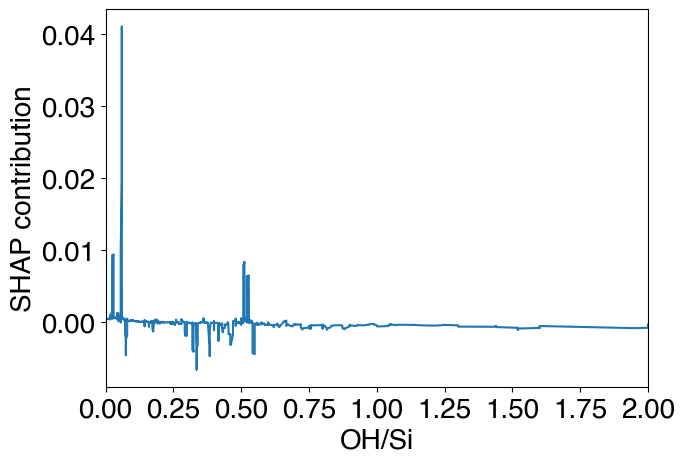

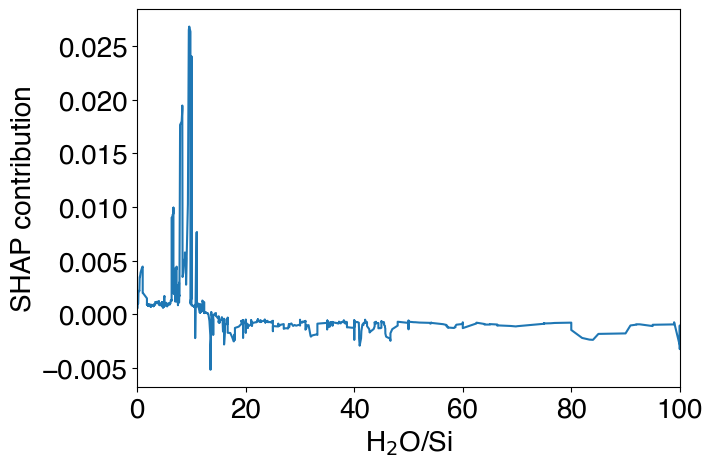

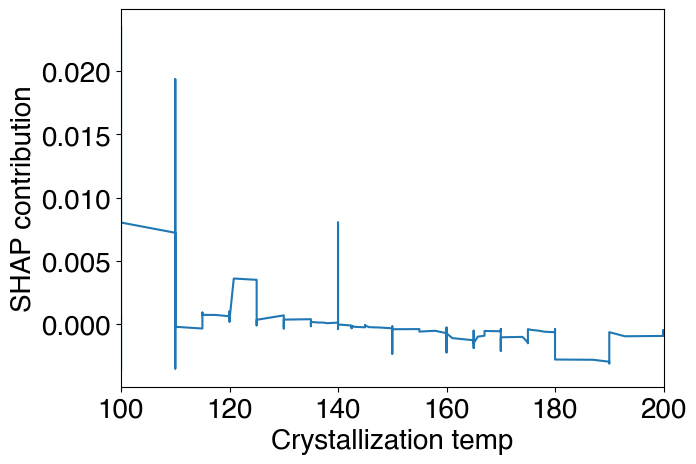

In [27]:
dependence_plot(zeo='RHO', feat='Cs/Si', xmin=0., xmax=.5, top_n=5, smooth=True)
dependence_plot(zeo='RHO', feat='Na/Si', xmin=0., xmax=1., top_n=5, smooth=True)
dependence_plot(zeo='RHO', feat='OH/Si', xmin=0., xmax=2., top_n=5, smooth=True)
dependence_plot(zeo='RHO', feat='H$_2$O/Si', xmin=0., xmax=100., top_n=5, smooth=True)
dependence_plot(zeo='RHO', feat='Crystallization temp', xmin=100., xmax=200., top_n=5, smooth=True)

Na/Si         0.228802
SHAP value    0.075592
dtype: float64
OH/Si         2.448301
SHAP value    0.083219
dtype: float64
H$_2$O/Si     17.000000
SHAP value     0.072471
dtype: float64
Crystallization temp    96.000000
SHAP value               0.140936
dtype: float64


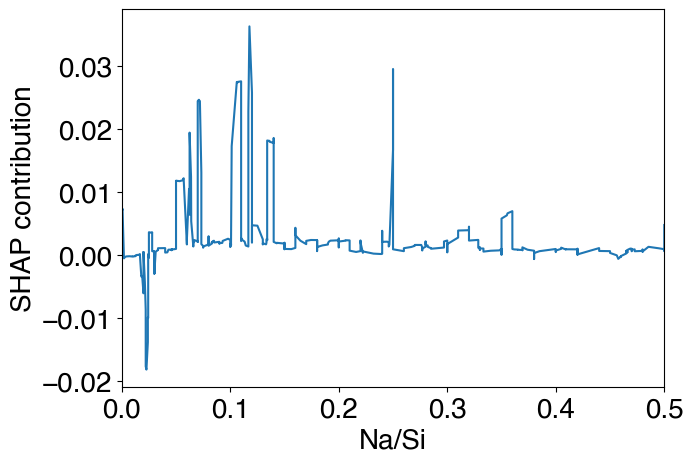

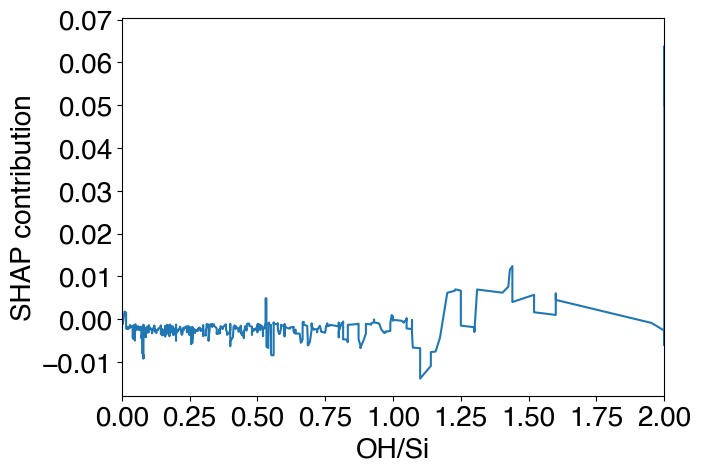

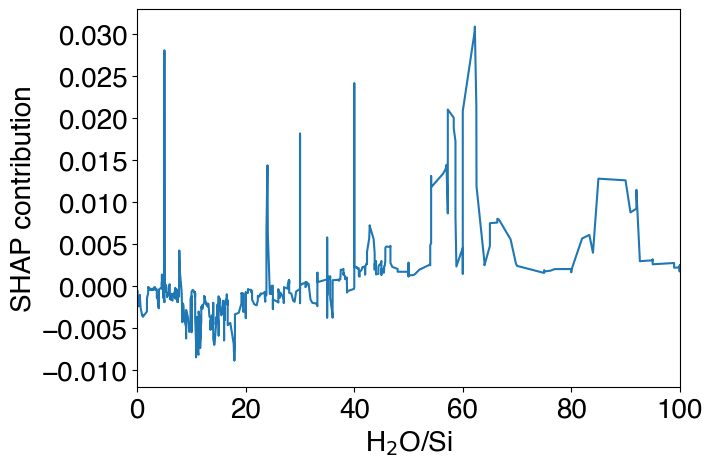

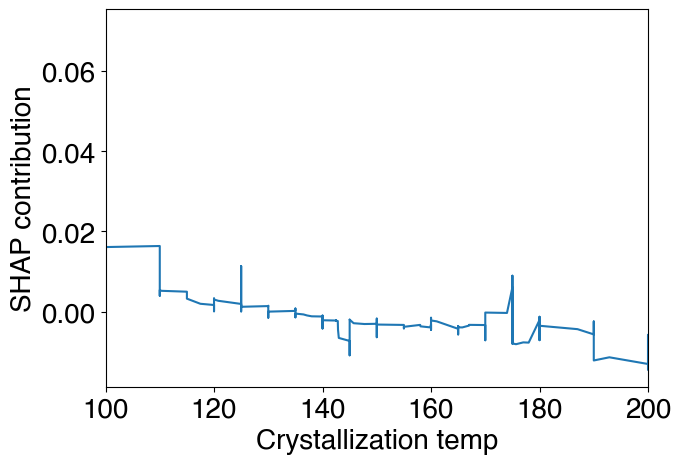

In [28]:
dependence_plot(zeo='LTA', feat='Na/Si', xmin=0., xmax=0.5, top_n=5, smooth=True)
dependence_plot(zeo='LTA', feat='OH/Si', xmin=0., xmax=2., top_n=5, smooth=True)
dependence_plot(zeo='LTA', feat='H$_2$O/Si', xmin=0., xmax=100., top_n=5, smooth=True)
dependence_plot(zeo='LTA', feat='Crystallization temp', xmin=100., xmax=200., top_n=5, smooth=True)

Na/Si         0.090414
SHAP value    0.005376
dtype: float64
OH/Si         2.040000
SHAP value    0.023726
dtype: float64
H$_2$O/Si     30.000000
SHAP value     0.017364
dtype: float64
Crystallization temp    148.000000
SHAP value                0.007928
dtype: float64


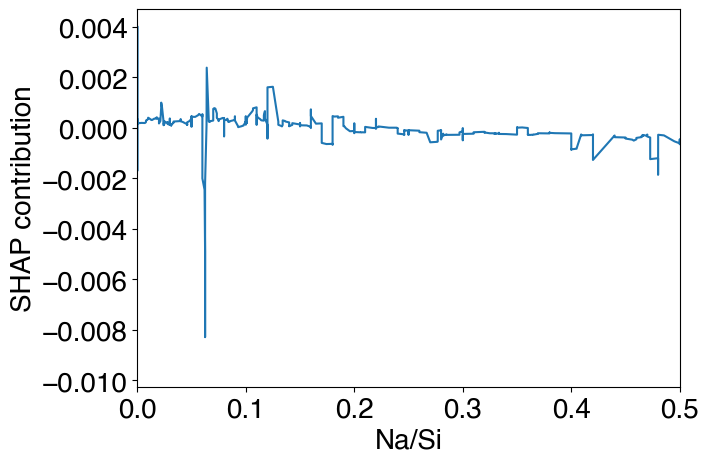

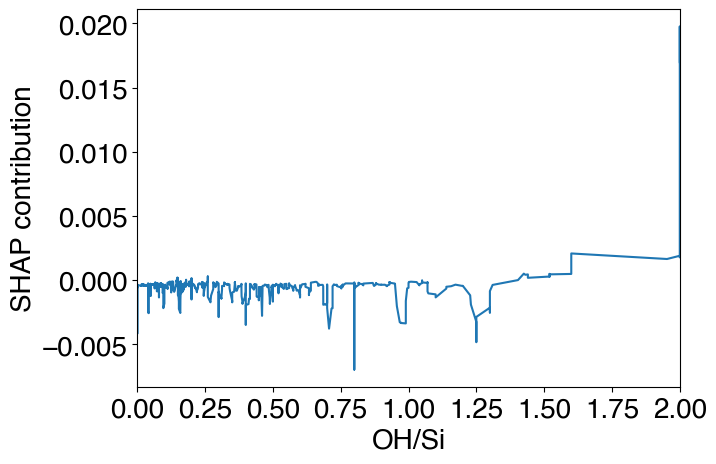

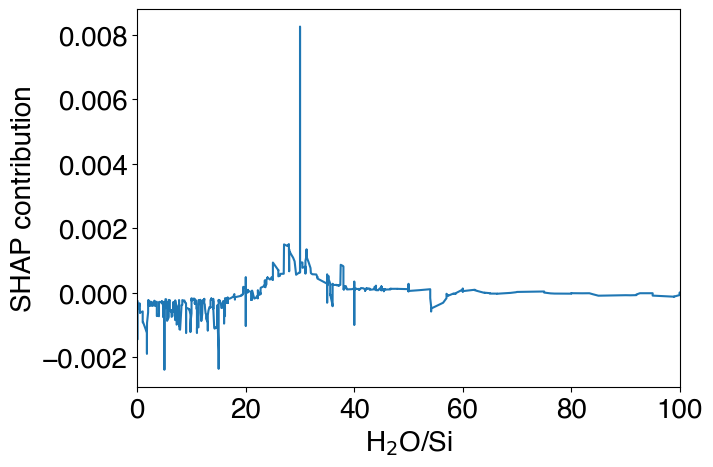

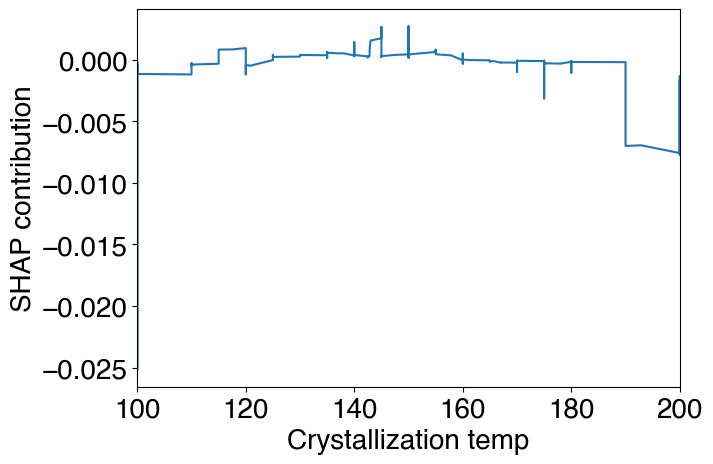

In [29]:
dependence_plot(zeo='UFI', feat='Na/Si', xmin=0., xmax=0.5, top_n=5, smooth=True)
dependence_plot(zeo='UFI', feat='OH/Si', xmin=0., xmax=2., top_n=5, smooth=True)
dependence_plot(zeo='UFI', feat='H$_2$O/Si', xmin=0., xmax=100., top_n=5, smooth=True)
dependence_plot(zeo='UFI', feat='Crystallization temp', xmin=100., xmax=200., top_n=5, smooth=True)

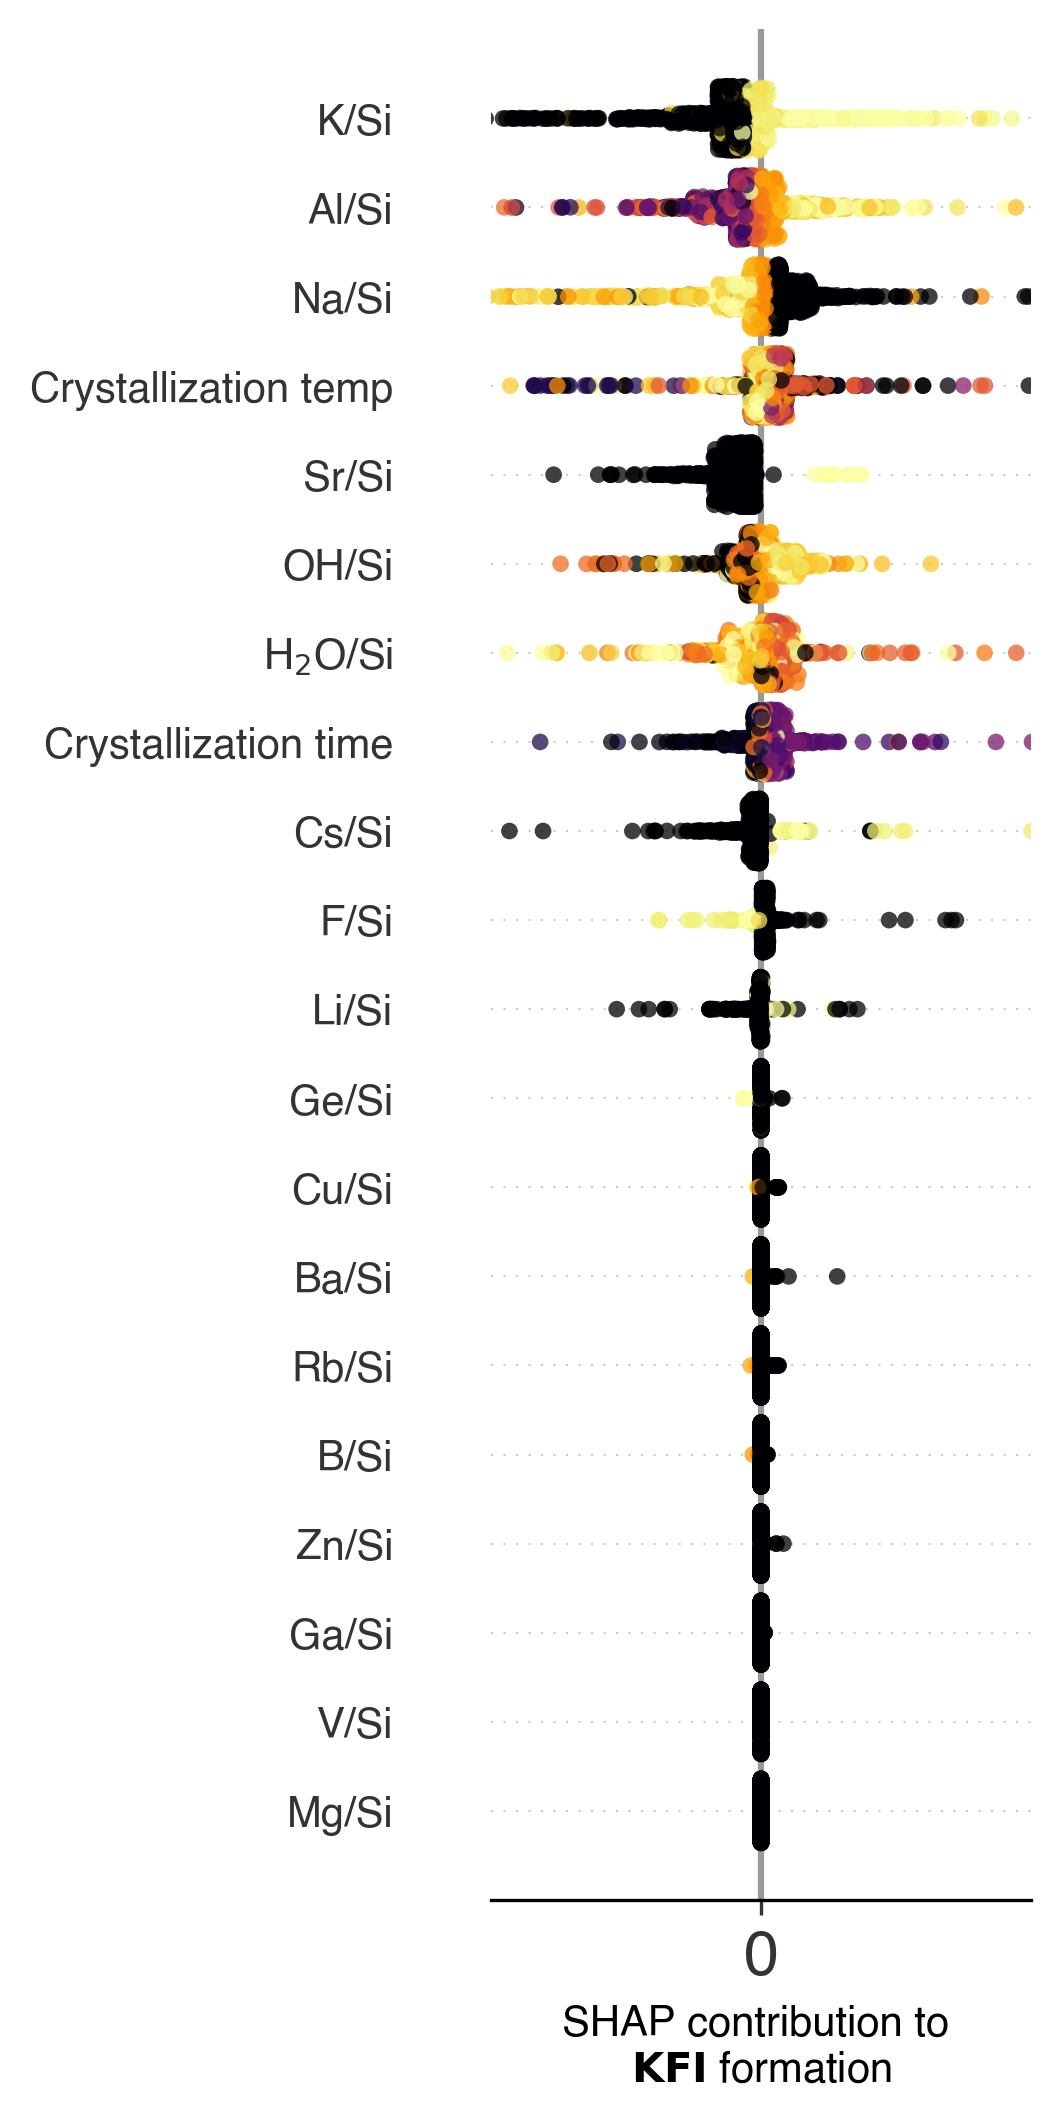

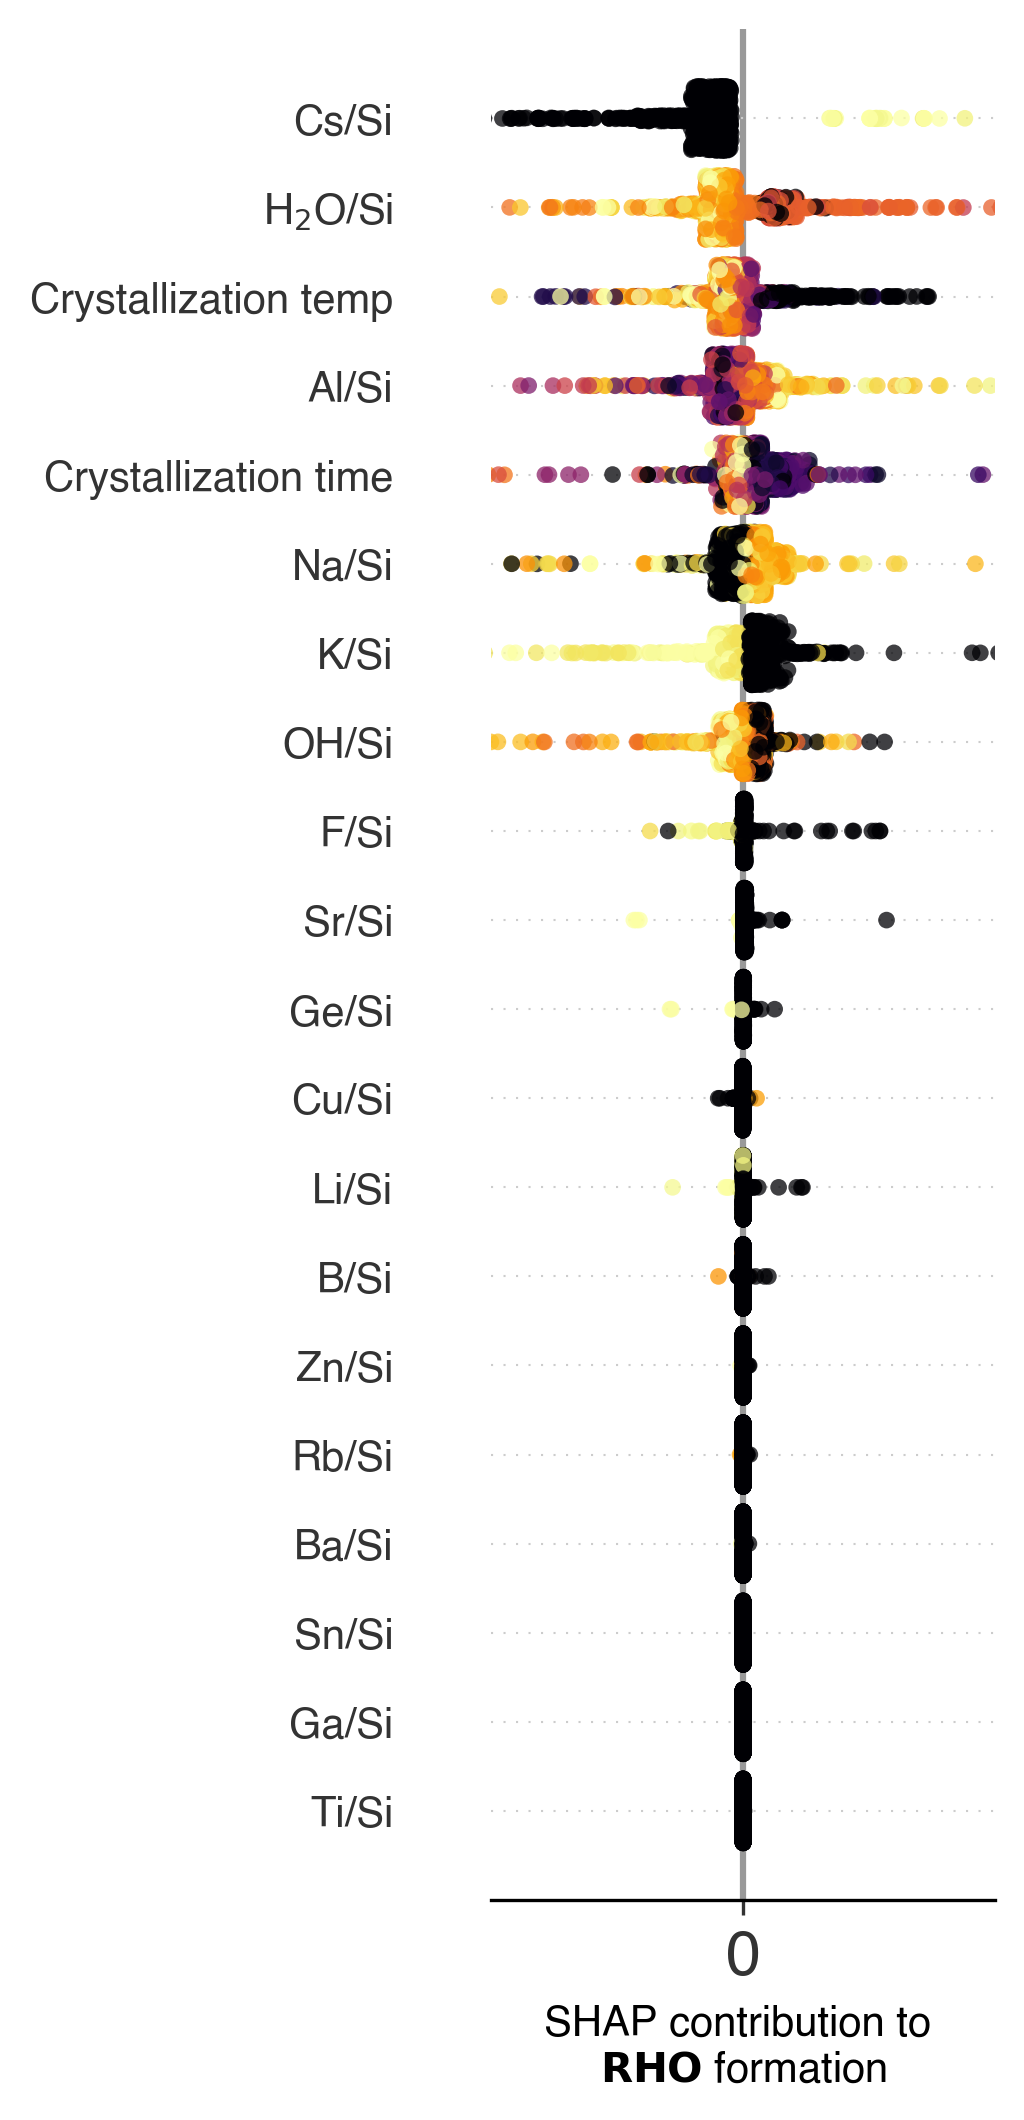

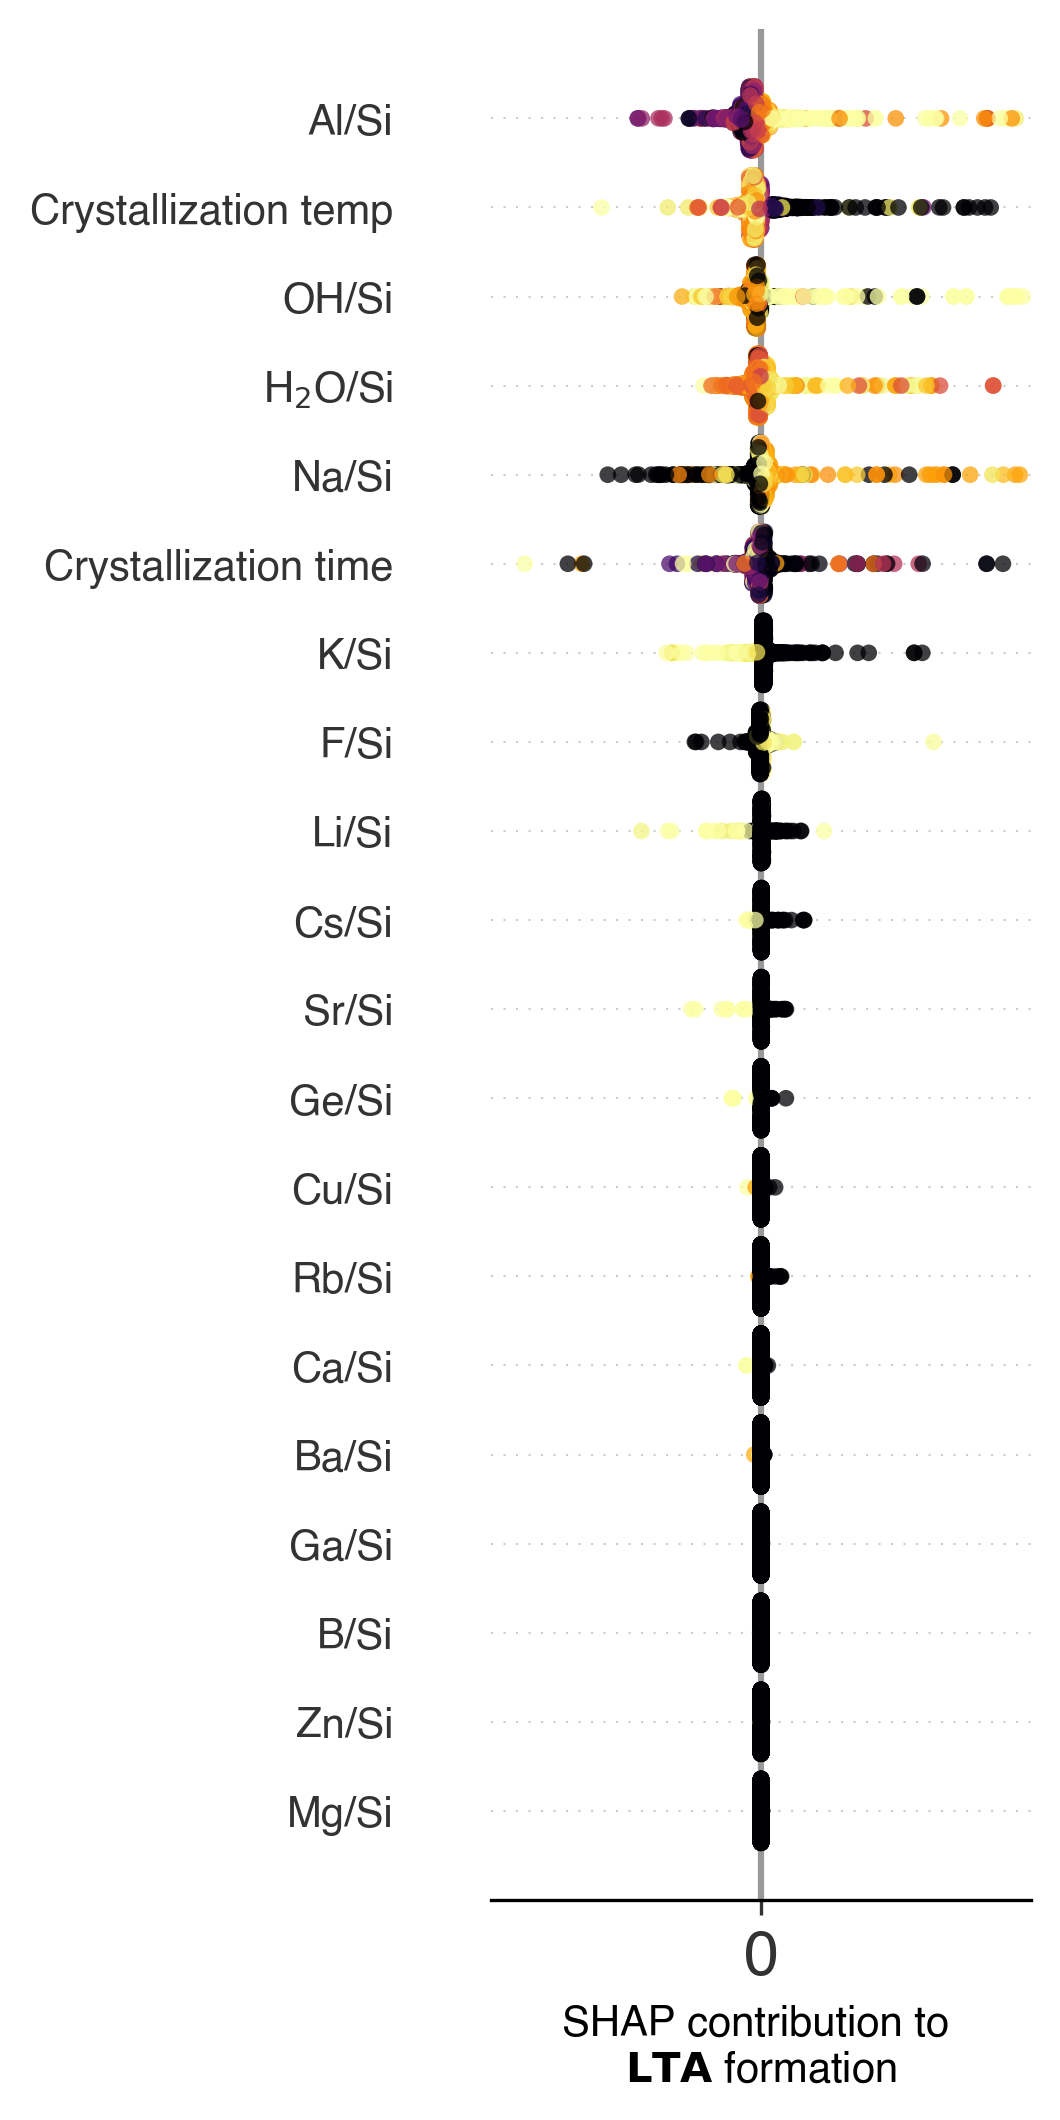

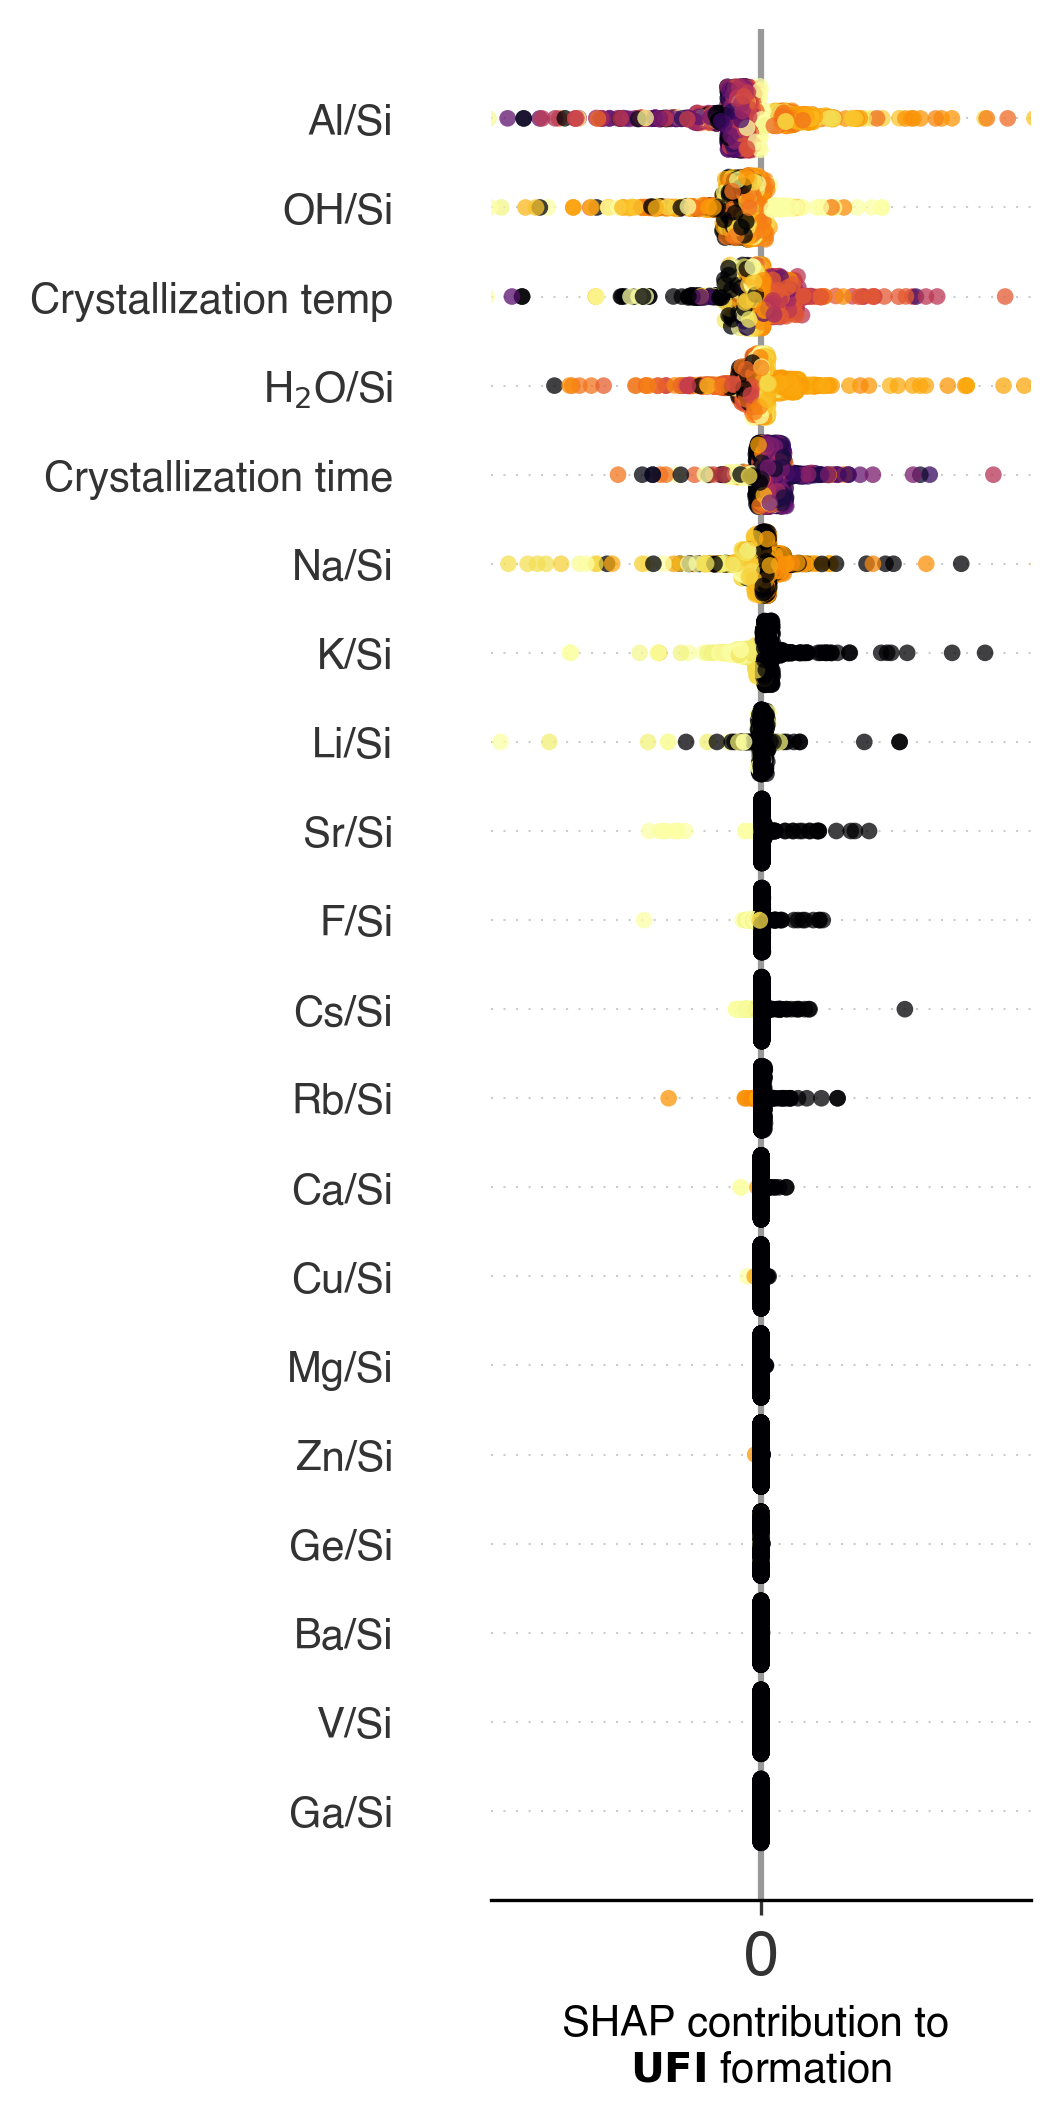

In [36]:
# Framework-level SHAP example
for zeo in ['KFI', 'RHO', 'LTA', 'UFI']:
    plot_zeo_shap(zeo, cols=[x for x in X_cols.values() if 'OSDA' not in x], cmap=cmap, alpha=0.75, max_display=None, plot_size=(4,7), xlabel_size=10, color_bar=False, savepath=f'KFI-RHO-LTA-UFI_paper/figs/{zeo}_fw.pdf')

In [38]:
X_cols.keys()

dict_keys(['Al/Si', 'P/Si', 'Na/Si', 'K/Si', 'Li/Si', 'Sr/Si', 'Rb/Si', 'Cs/Si', 'Ba/Si', 'Ca/Si', 'F/Si', 'Ge/Si', 'Ti/Si', 'B/Si', 'Mg/Si', 'Ga/Si', 'Zn/Si', 'Be/Si', 'W/Si', 'Cu/Si', 'Sn/Si', 'Zr/Si', 'V/Si', 'H2O/Si', 'sda1/Si', 'OH/Si', 'cryst_time', 'cryst_temp', 'osda1_asphericity_mean_0', 'osda1_axes_mean_0', 'osda1_axes_mean_1', 'osda1_formal_charge', 'osda1_free_sasa_mean_0', 'osda1_mol_weight', 'osda1_npr1_mean_0', 'osda1_npr2_mean_0', 'osda1_num_rot_bonds_mean_0', 'osda1_pmi1_mean_0', 'osda1_pmi2_mean_0', 'osda1_pmi3_mean_0', 'osda1_spherocity_index_mean_0', 'osda1_volume_mean_0'])

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


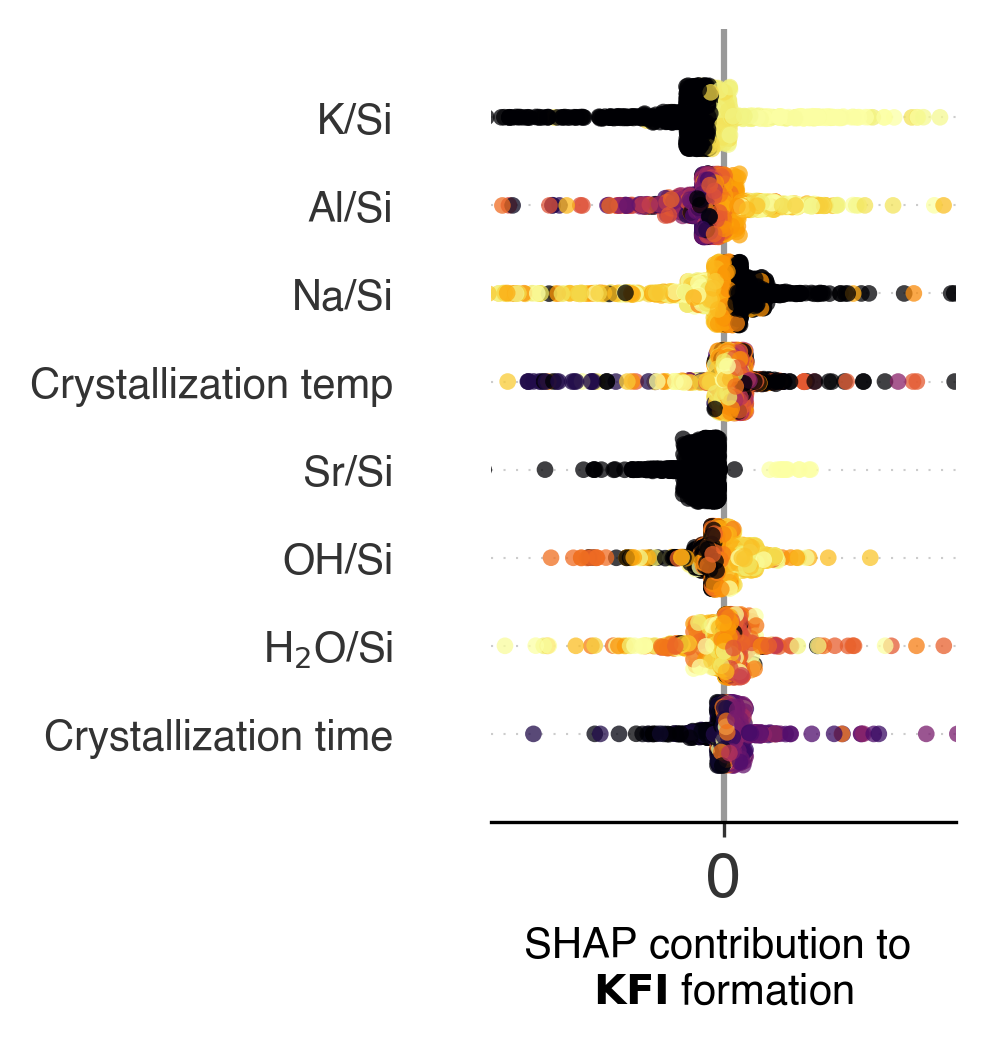

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


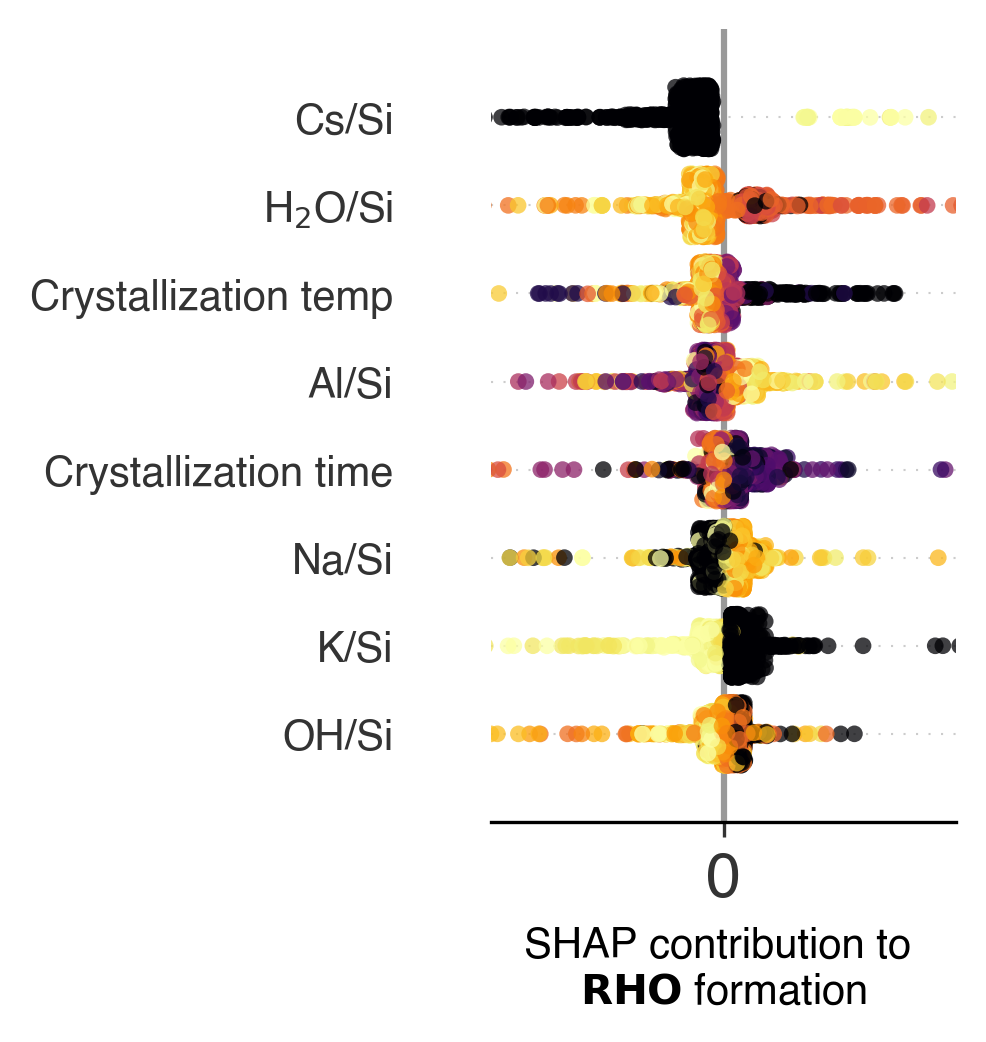

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


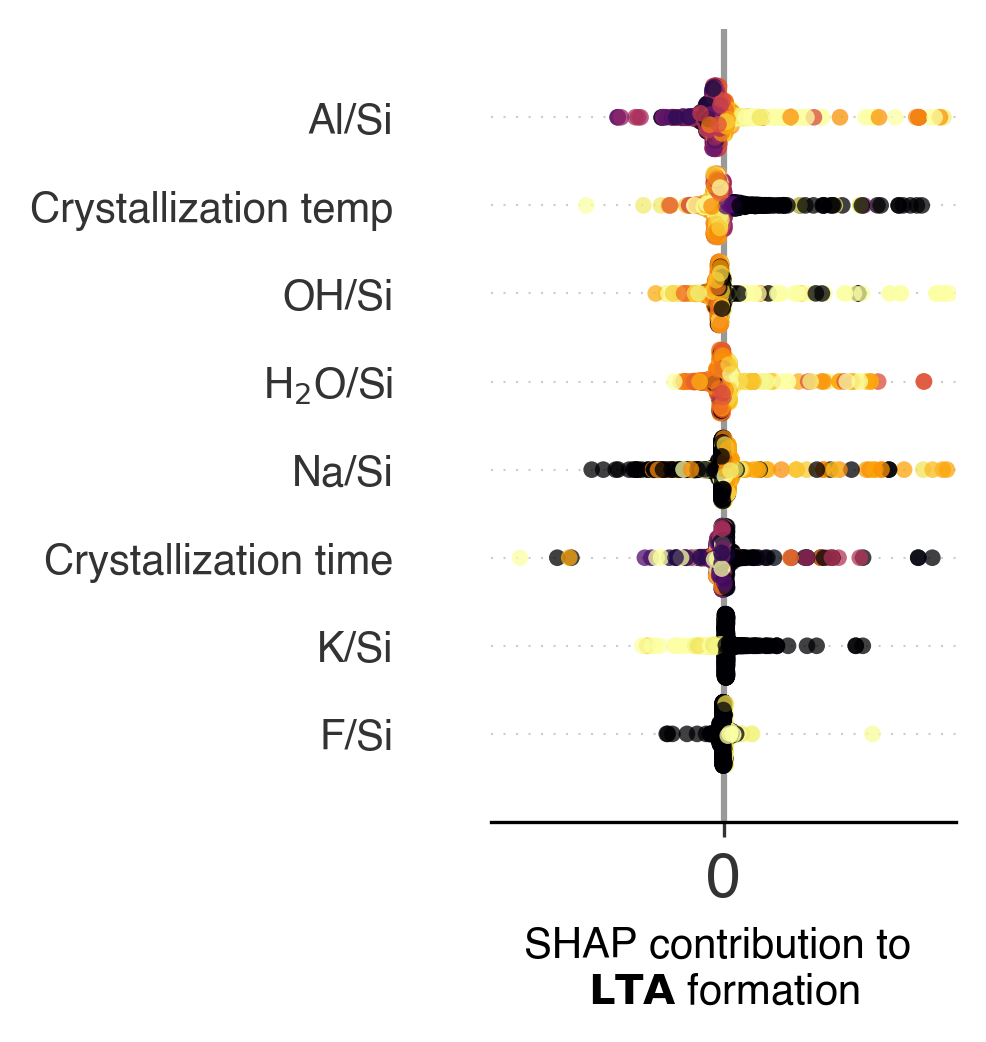

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


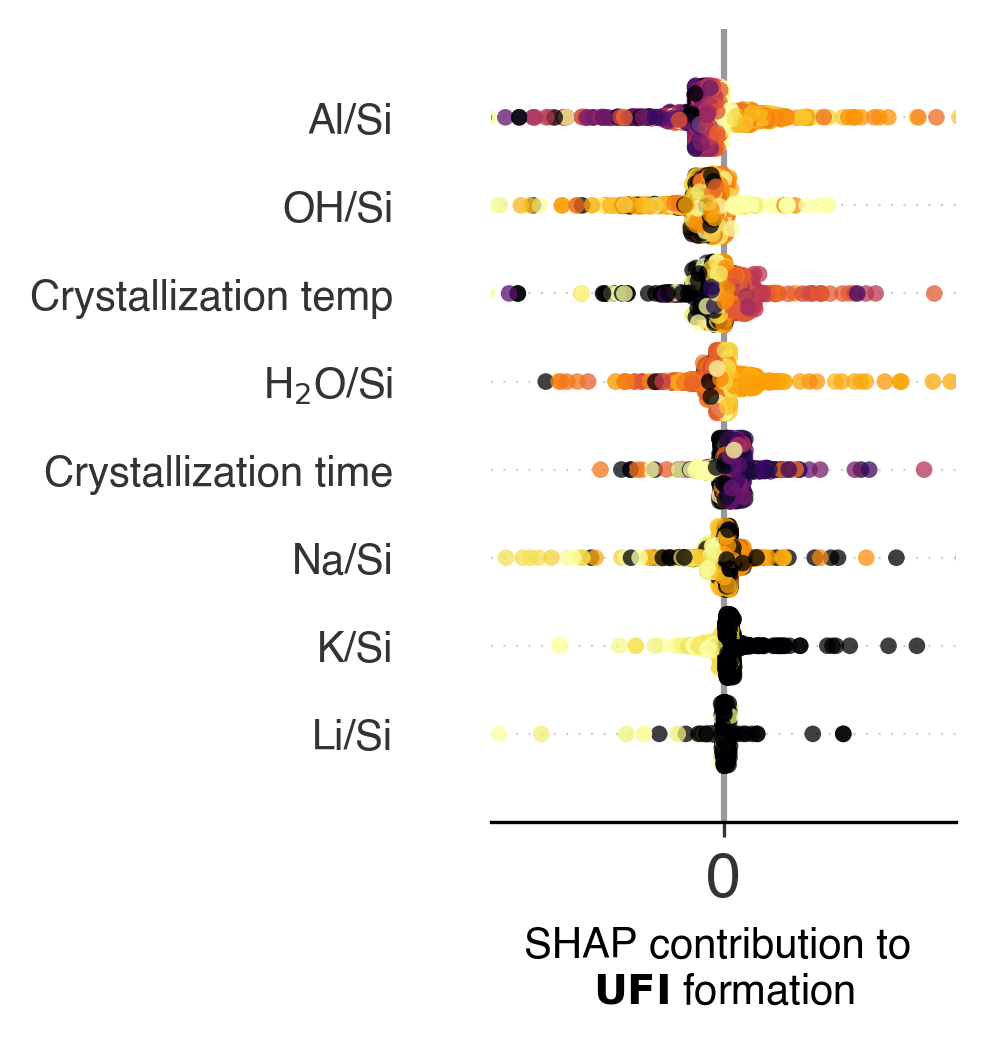

In [41]:
# Truncated-version of framework-level SHAP
for zeo in ['KFI', 'RHO', 'LTA', 'UFI']:
    plot_zeo_shap(zeo, cols=[x for x in X_cols.values() if ('OSDA' not in x) and ('cryst' not in x)], cmap=cmap, alpha=0.75, max_display=8, plot_size=(2,3.5), xlabel_size=10, color_bar=False, savepath=f'KFI-RHO-LTA-UFI_paper/figs/{zeo}_fw_trunc.pdf')

## CBU-level SHAP

In [31]:
df_zeos['cbu'] = list(map(clean_cbus, df_zeos['cbu'].values))
df_zeos['Code'] = df_zeos['Code'].apply(rename_disordered_interrupted)

In [32]:
# Find unique set of cbus present in dataset
cbus_unique = []
for cbu_combination in df_zeos['cbu'].value_counts().index:
    for cbu in cbu_combination:
        if cbu not in cbus_unique:
            cbus_unique.append(cbu)

# Get one-hot encoding of cbus
cbu_oh = np.zeros([len(df_zeos), len(cbus_unique)]) # initialize one-hot encoding with zeros
cbu_oh = pd.DataFrame(cbu_oh, columns = cbus_unique, index = df_zeos.index)

for idx in df_zeos.index:
    cbus = df_zeos.loc[idx]['cbu']

    if (cbus == None) or (len(cbus) == 0): # either None or empty list
        pass
    elif (len(cbus) > 0) and (type(cbus) == list): # if non-empty list of cbus exists 

        for cbu in cbus: # modify one-hot encoding of cbus
            cbu_oh.loc[idx, cbu] = 1.0

# append one-hot encoding of CBUs to df_zeos
df_zeos = pd.concat([df_zeos, cbu_oh], axis = 1)

In [33]:
def plot_cbu_shap(cbu, cols, max_display = 5, plot_size = (8,5), xlim = None, alpha = 0.1, cmap = 'coolwarm', xlabel_size = None, color_bar = True, sort = True, return_top_shap_feats = False, savepath = None):
    '''
    Plots SHAP plot for a specific composite building unit (CBU)
    
    Args:
    cbu: CBU 3-letter code
    cols: synthesis feature columns to consider
    '''
    
    # Construct SHAP matrix for a specific CBU

    zeos_with_cbu = []
    zeos_wo_cbu = []
    zeo_idxs = []
    zeo_wo_idxs = []
    for zeo in df_zeos['Code']:
        if (zeo in model.classes_):
            if (df_zeos[df_zeos['Code'] == zeo][cbu] == 1.).item(): # if CBU present
                zeo_idx = np.where(model.classes_ == zeo)[0][0]
                zeo_idxs.append(zeo_idx)
                zeos_with_cbu.append(zeo)

            else: # else CBU not present
                zeo_idx = np.where(model.classes_ == zeo)[0][0]
                zeo_wo_idxs.append(zeo_idx)
                zeos_wo_cbu.append(zeo)


    cbu_shap = [pd.DataFrame(shap_values_masked[zeo_idx], columns = X_cols.values())[cols] for zeo_idx in zeo_idxs] # Get SHAP values for zeos with this CBU
    cbu_not_present_shap = [pd.DataFrame(shap_values_masked[zeo_wo_idx], columns = X_cols.values())[cols] for zeo_wo_idx in zeo_wo_idxs] # Get SHAP values for zeos without this CBU

    sum_shap = np.zeros_like(cbu_shap[0]) # Initialize final SHAP matrix

    for m in cbu_shap: # Add up SHAP matrices contributing to a specific CBU
        sum_shap += m

    # Summary plot
    plt.figure(dpi = 300)
    shap.summary_plot(np.array(sum_shap), 
                      X_test_masked[cols],
                    max_display = max_display,
                    cmap = cmap, show = False, alpha = alpha, color_bar_label='Synthesis parameter',
                    plot_size = plot_size,
                    color_bar = color_bar,
                    sort = sort,
                      
                     )
    fig, ax = plt.gcf(), plt.gca()
    
    top_shap_feat = ax.get_yticklabels()[-1].get_text() # str of feature name
    top_shap_feat_ub = np.quantile(sum_shap[top_shap_feat], 0.99)*1.2 # upper
    top_shap_feat_lb = np.quantile(sum_shap[top_shap_feat], 0.01)*1.2 # lower
    
    ax.set_xlabel('SHAP contribution to \n $\it{' + cbu + '}$ formation', fontsize = xlabel_size)
    plt.xticks(fontsize=15)
    
    if xlabel_size != None:
        ax.tick_params(axis='y', which='major', labelsize=xlabel_size)
        
    if xlim != None:
        ax.set_xlim(*xlim)
    else:
        ax.set_xlim(-max([top_shap_feat_ub, top_shap_feat_lb]), max([top_shap_feat_ub, top_shap_feat_lb]))
    
    plt.xticks([0.])
    
    if savepath != None:
        plt.savefig(savepath, dpi=200, bbox_inches='tight')
    
    if return_top_shap_feats: # return a list of top SHAP features
        top_shap_feats = [ax.get_yticklabels()[-i].get_text() for i in range(max_display)]
        plt.close(fig)
        return top_shap_feats
    else:
        plt.show()

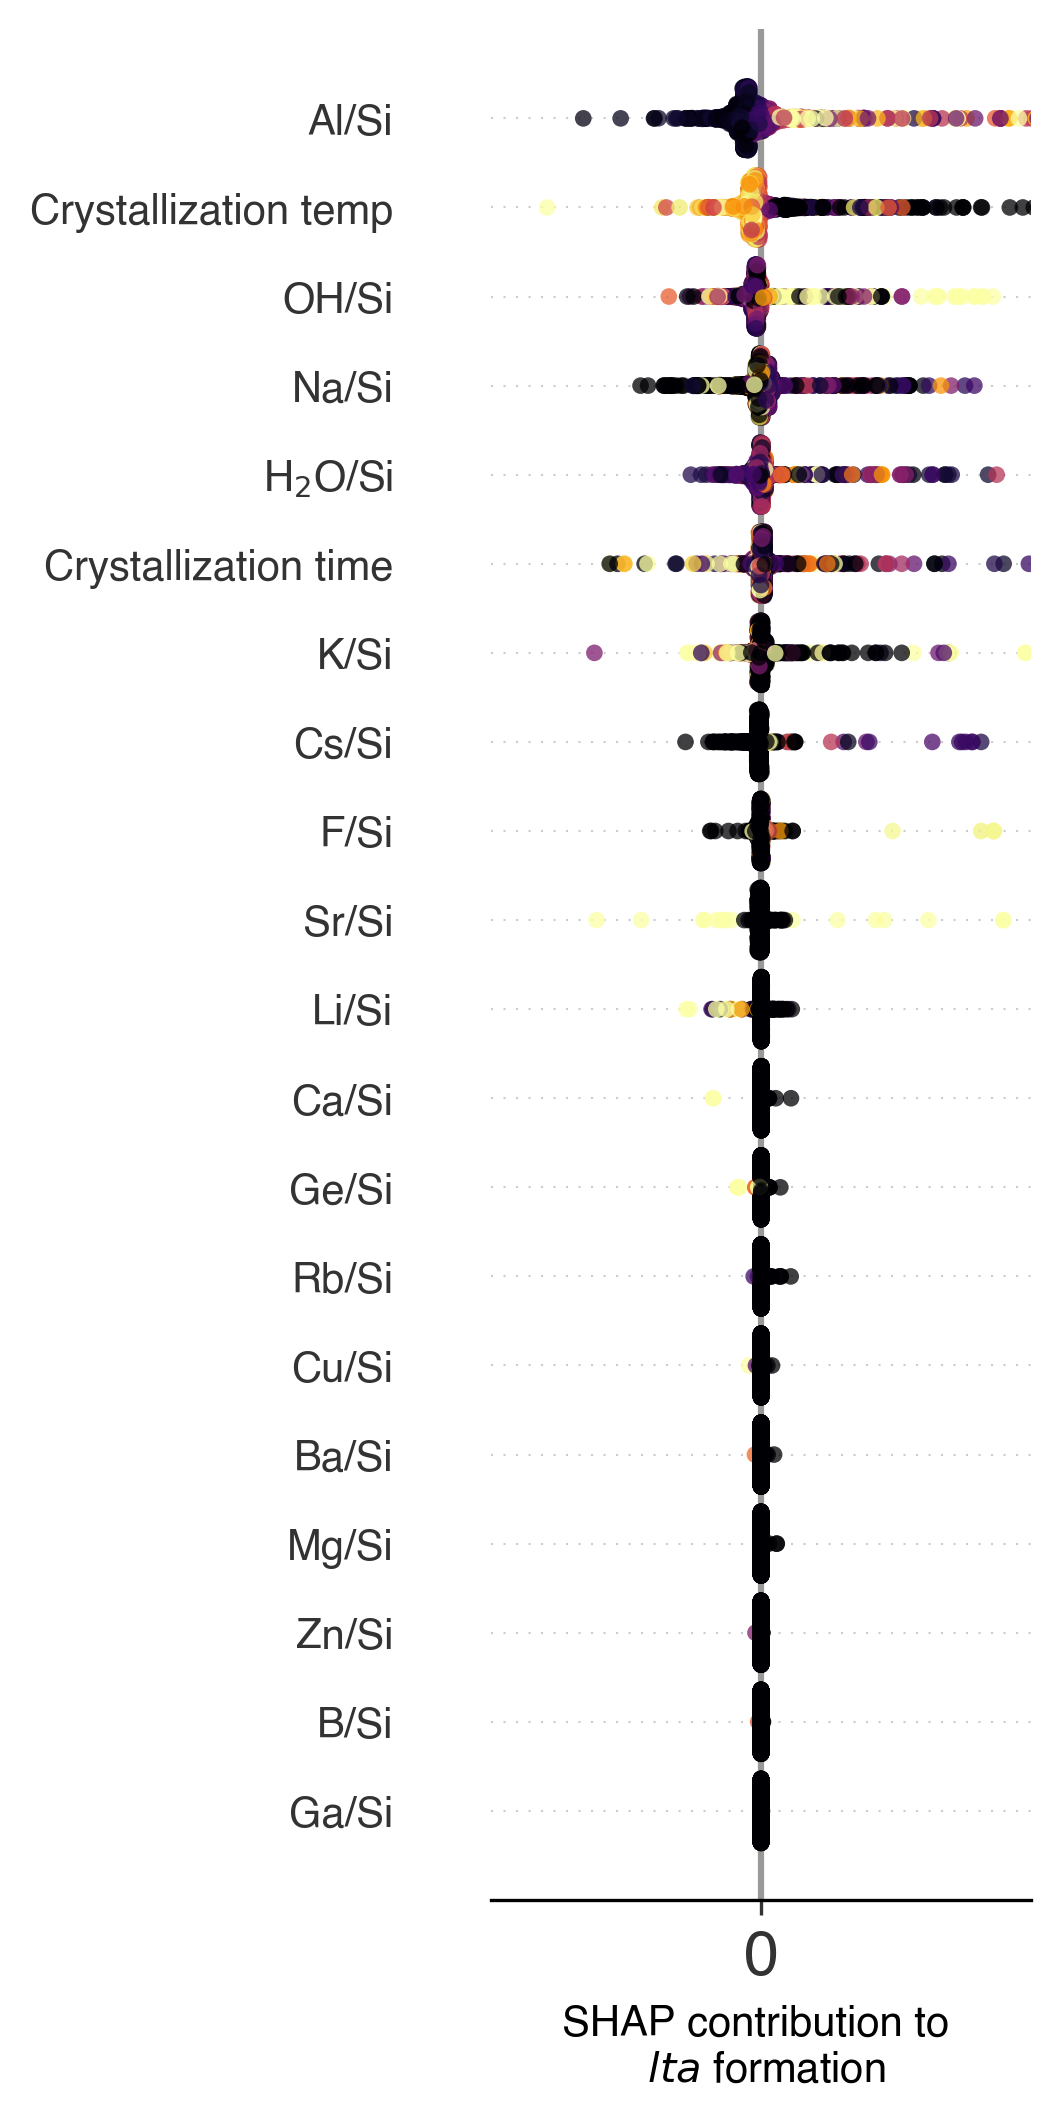

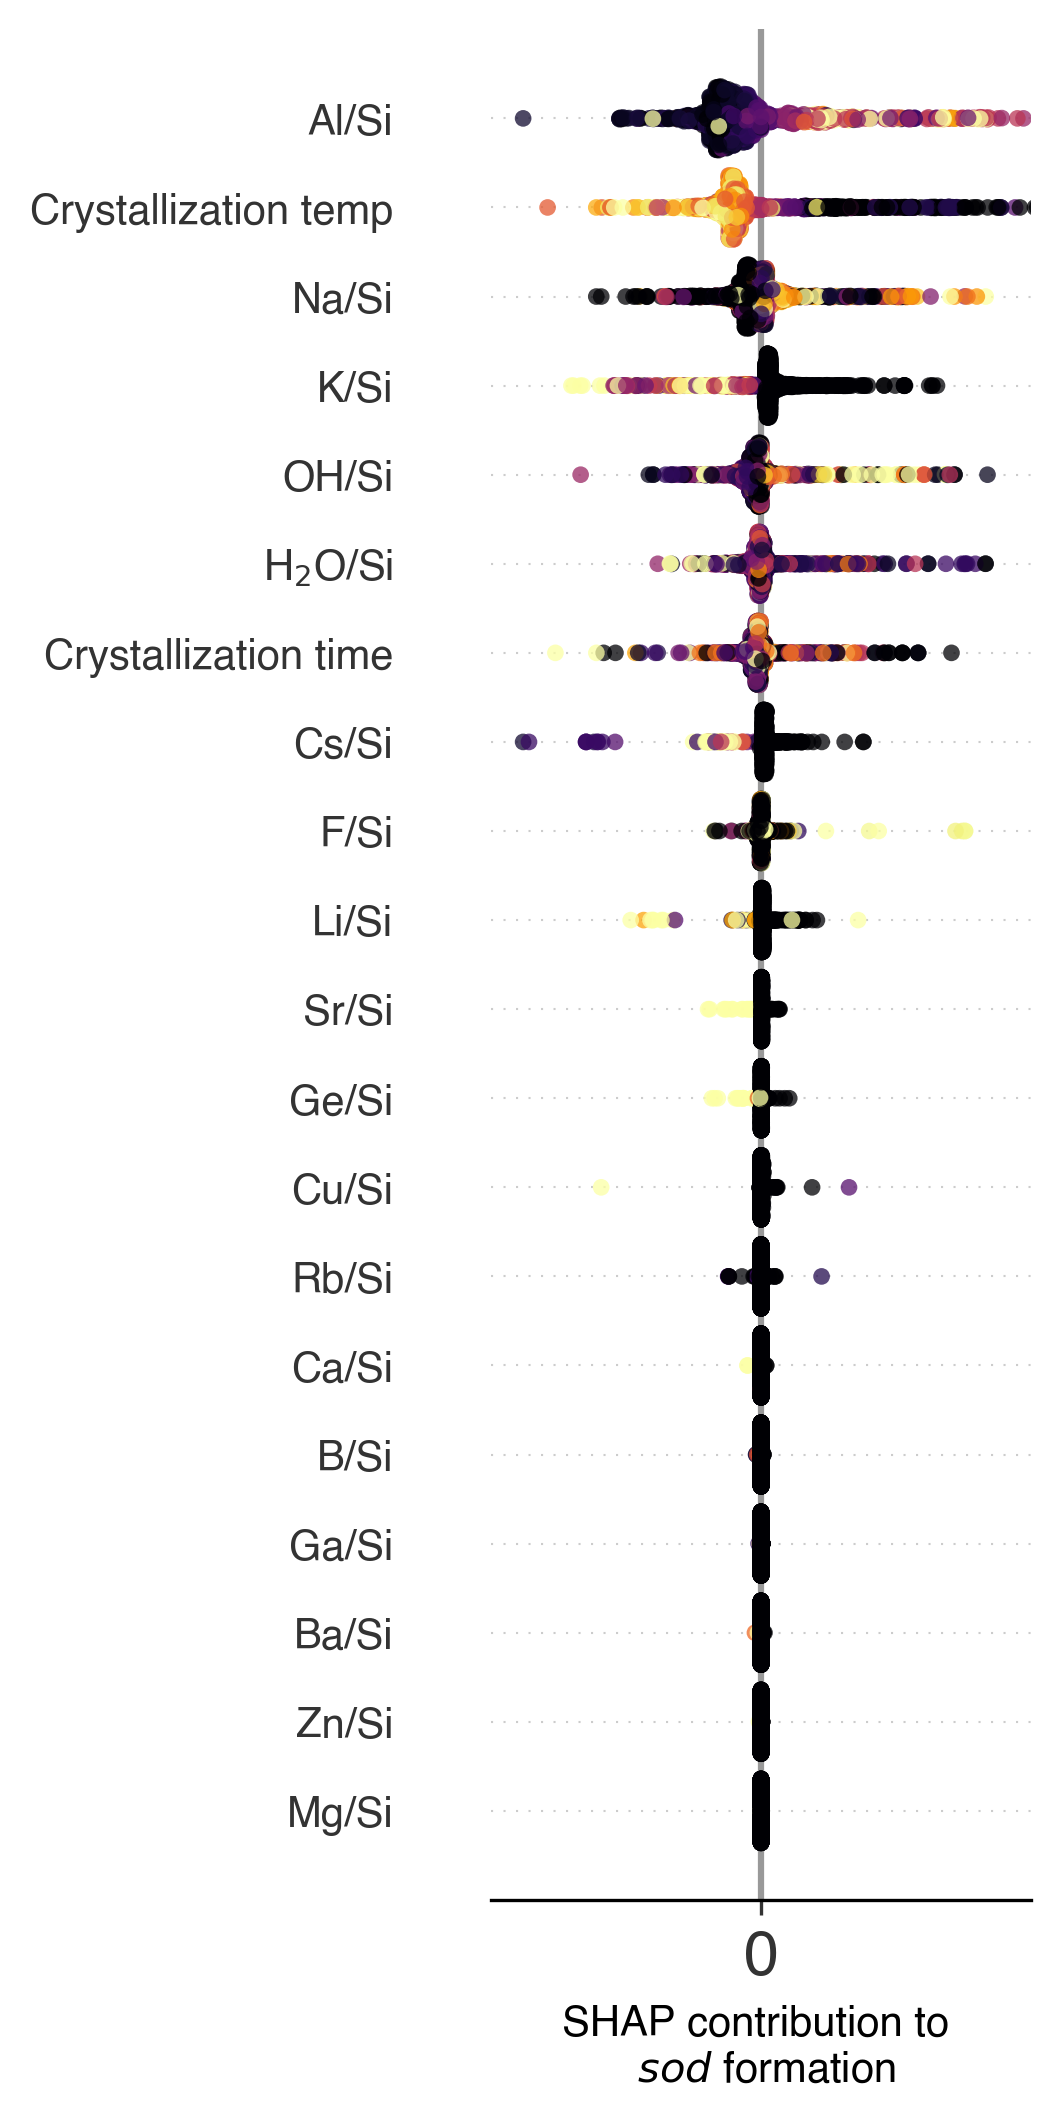

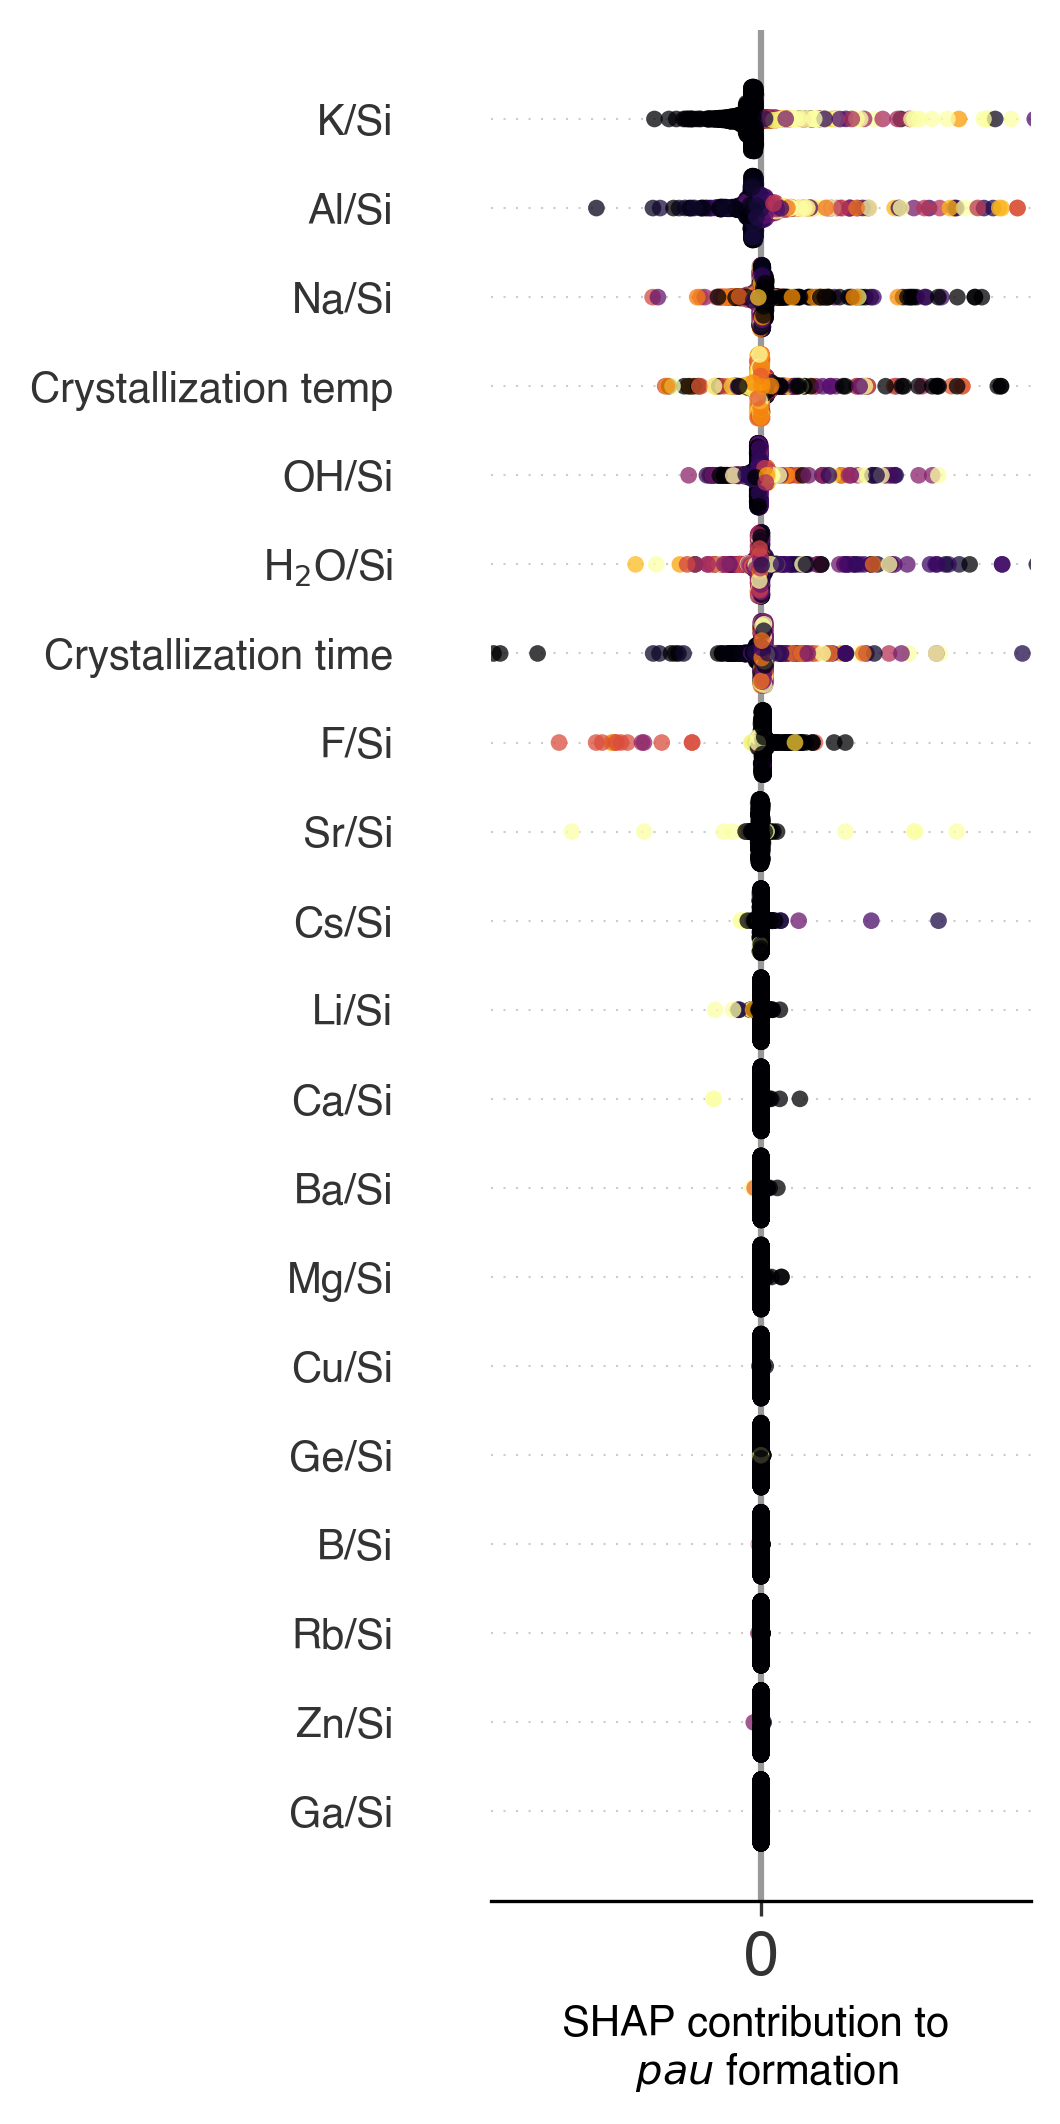

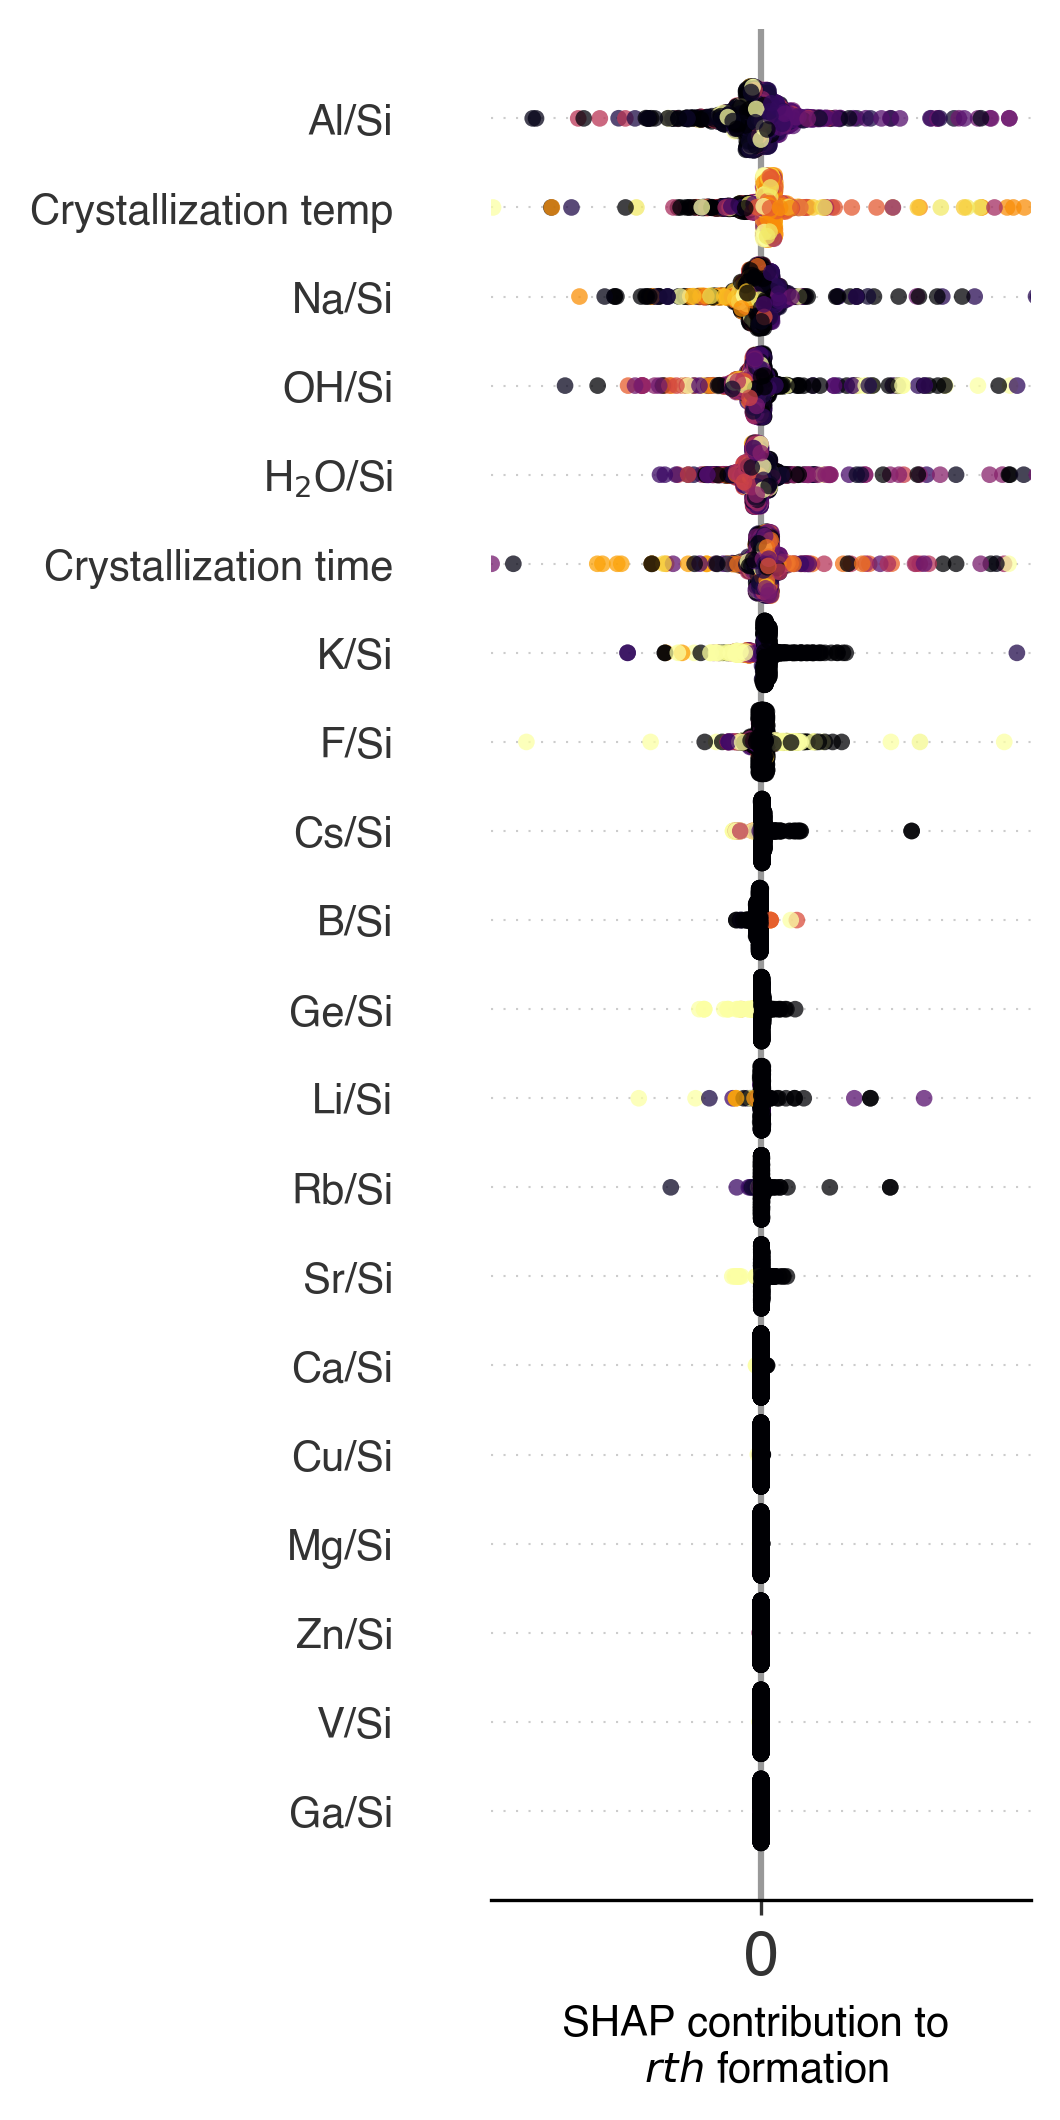

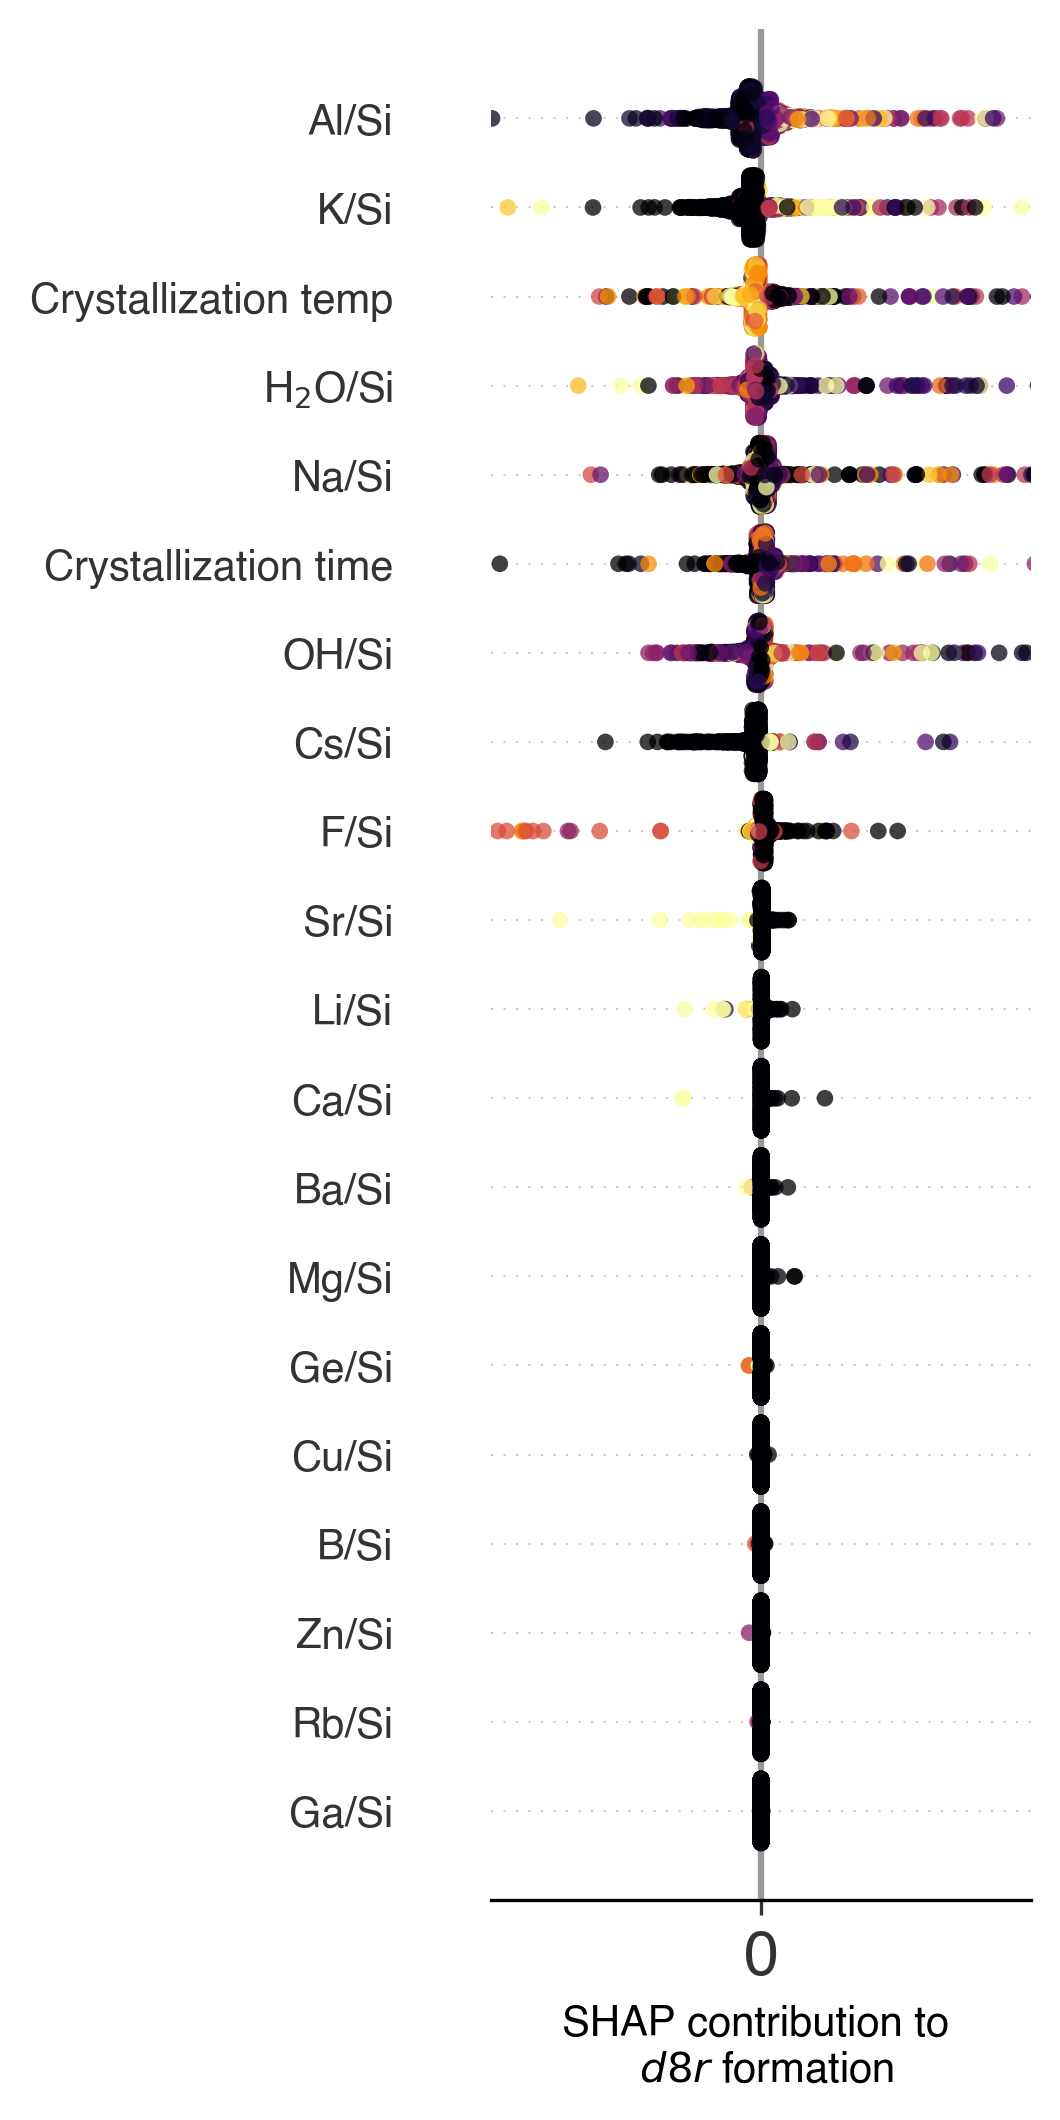

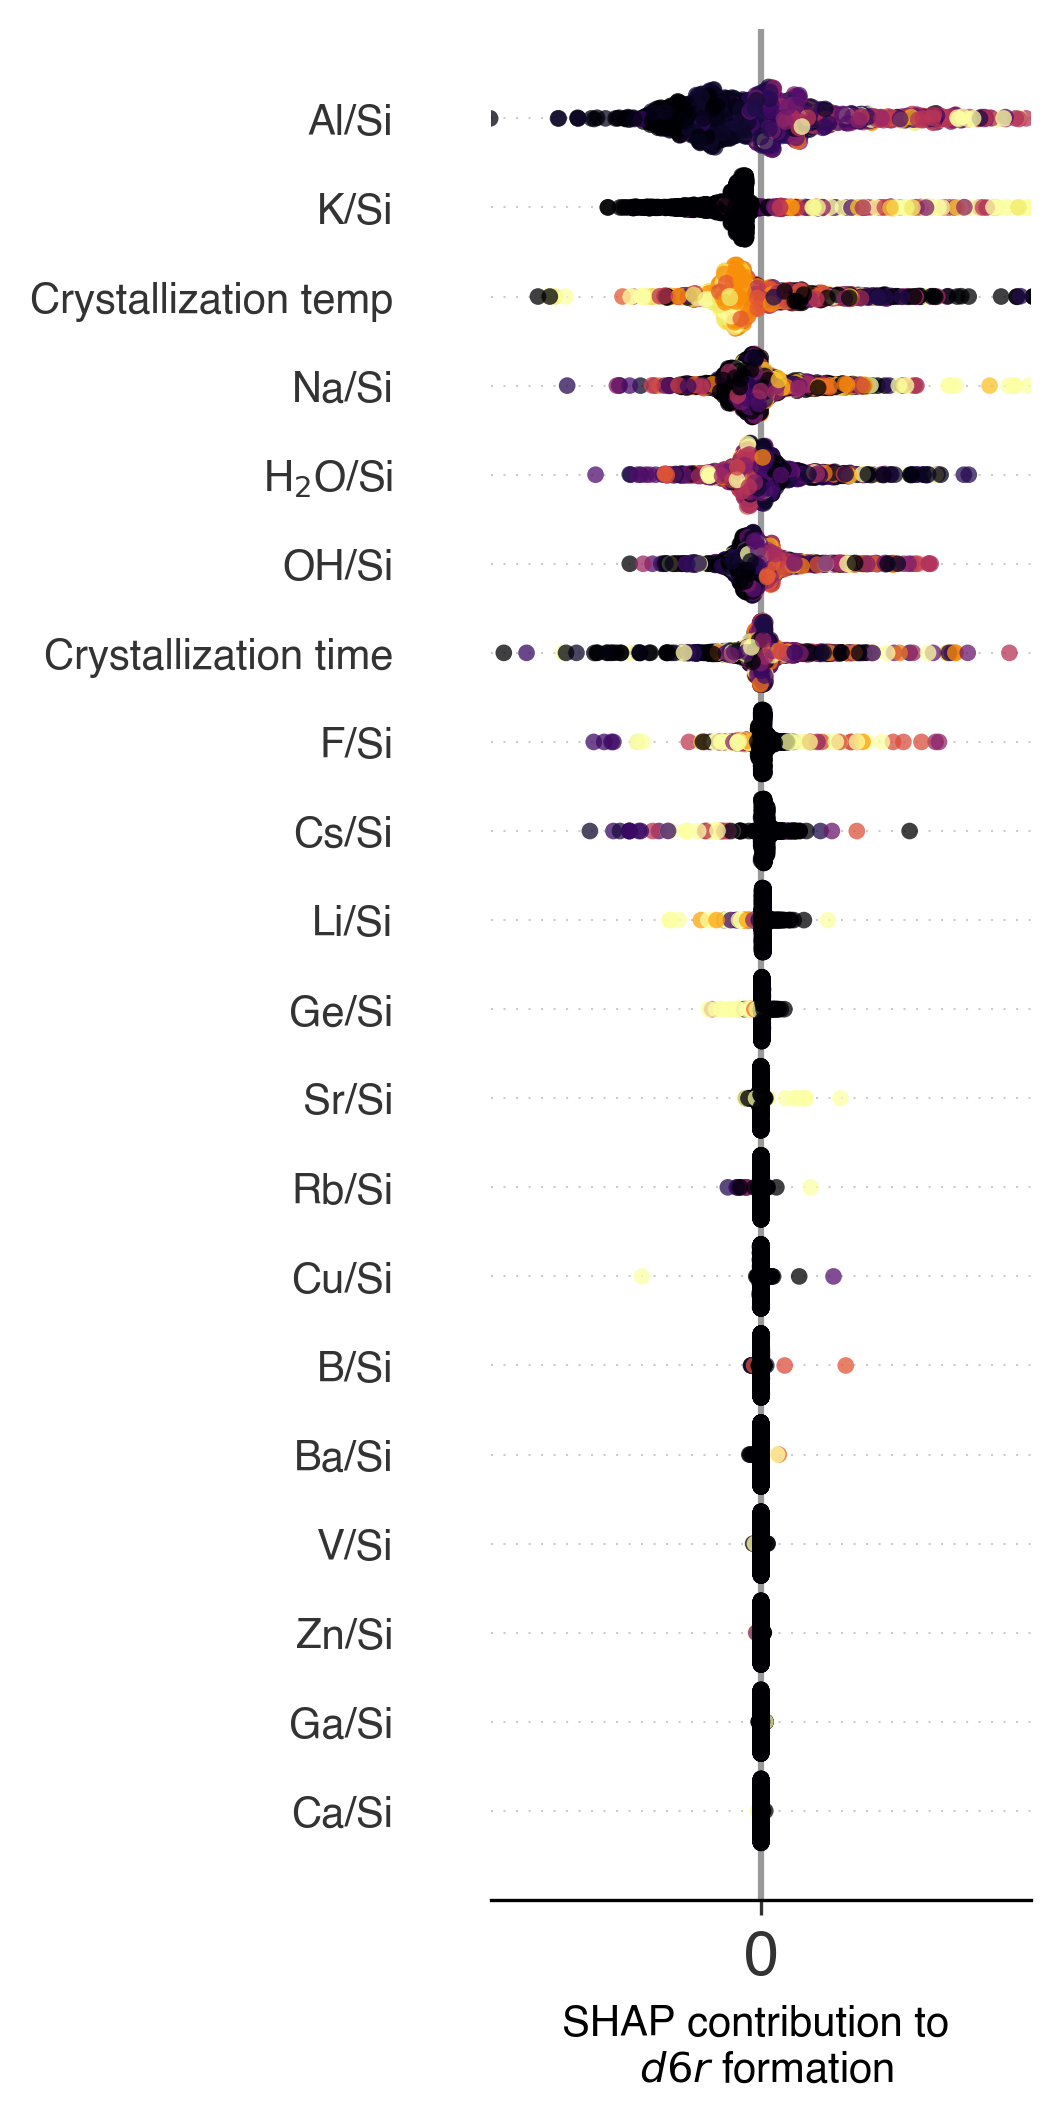

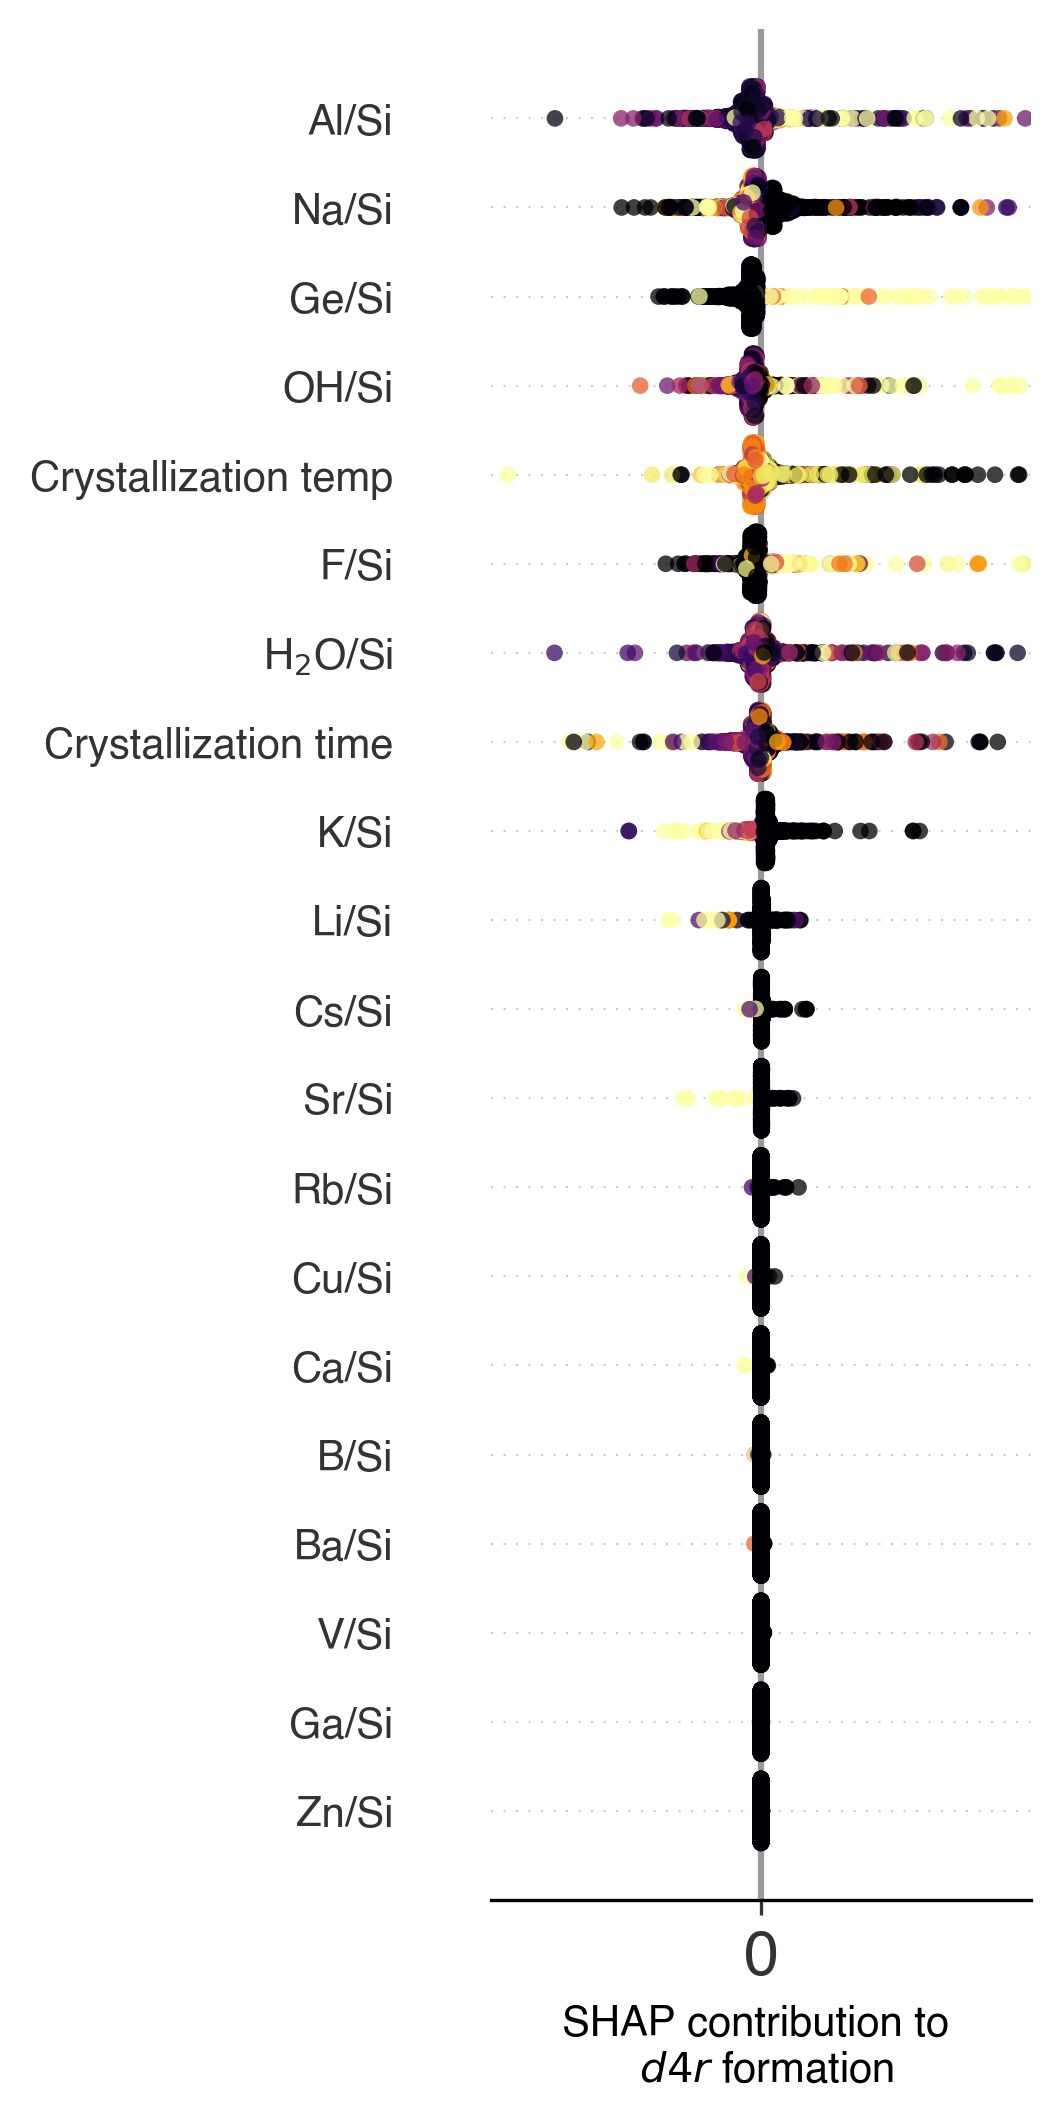

In [34]:
for cbu in ['lta', 'sod', 'pau', 'rth', 'd8r', 'd6r', 'd4r']: # list of CBUs to plot
    plot_cbu_shap(cbu, cols = [x for x in X_cols.values() if 'OSDA' not in x], cmap = cmap, alpha = 0.75, max_display=None, plot_size=(4,7), xlabel_size=10, color_bar=False, savepath=f'KFI-RHO-LTA-UFI_paper/figs/{cbu}.pdf')